# Application d'un modèle SplineDist custom
Notebook made by Marine Silvin (silvinm@igbmc.fr)

Ce notebook a pour but de permettre de faire tourner un modèle déjà pré-entrainé de segmentation basé sur splinedist (https://github.com/uhlmanngroup/splinedist). Cela permet d'extraire les labelmap d'un dossier d'images sur lequel on appliquera le modèle de détection.

## Les imports

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible
from splinedist import fill_label_holes

from splinedist import random_label_cmap, _draw_polygons, export_imagej_rois
from splinedist.models import SplineDist2D
from splinedist.utils import iou_objectwise, iou 

from tkinter import *
from tkinter.filedialog import askdirectory
from tkinter.filedialog import askopenfilename

from matplotlib.pyplot import imsave

np.random.seed(6)
lbl_cmap = random_label_cmap()

import os
os.environ['CUDA_VISIBLE_DEVICES']=''

C:\ProgramData\Anaconda3\envs\splinedist\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  """


## Data

Ici, on choisira dans quel dossier se trouve les images sur lesquels le modèle sera appliqué. De plus, si il n'y a pas de dossier "Results" déjà présent, il sera crée.  

In [2]:
root = Tk()
root.withdraw()

# =============================================================================
#Choose your path directory
# =============================================================================
path = askdirectory(title='Select Working Folder (where your image are)') # shows dialog box and return the path
print(path+ '/*tif')
# os.chdir(path)

pathResult = path+'/Results'
if not os.path.exists(pathResult):
    os.makedirs(pathResult)
# print(pathResult)

# =============================================================================
#Display files in the folder
# =============================================================================

list2 = os.listdir(path)
for fichiers in list2:
    print(fichiers)

C:/Users/gestionimg/Desktop/Mehdi/Stack_deconv/*tif
20211126_MCF7-STARD3-FYAA-1.tif
20211126_MCF7-STARD3-FYAA-2.tif
20211126_MCF7-STARD3-FYAA-3.tif
20211126_MCF7-STARD3-FYAA-4.tif
20211126_MCF7-STARD3-FYAA-5.tif
20211126_MCF7-STARD3-FYAA-6.tif
20211126_MCF7-STARD3-FYAA-7.tif
20211126_MCF7-STARD3-FYAA-8.tif
20211126_MCF7-STARD3-WT-1.tif
20211126_MCF7-STARD3-WT-2.tif
20211126_MCF7-STARD3-WT-3.tif
20211126_MCF7-STARD3-WT-4.tif
20211126_MCF7-STARD3-WT-5.tif
20211126_MCF7-STARD3-WT-6.tif
20211126_MCF7-STARD3-WT-7.tif
20211126_MCF7-STARD3-WT-8.tif
20211202_MCF7-STARD3-FYAA-1.tif
20211202_MCF7-STARD3-FYAA-10.tif
20211202_MCF7-STARD3-FYAA-2.tif
20211202_MCF7-STARD3-FYAA-3.tif
20211202_MCF7-STARD3-FYAA-4.tif
20211202_MCF7-STARD3-FYAA-5.tif
20211202_MCF7-STARD3-FYAA-6.tif
20211202_MCF7-STARD3-FYAA-7.tif
20211202_MCF7-STARD3-FYAA-8.tif
20211202_MCF7-STARD3-FYAA-9.tif
Results


In [3]:
X = sorted(glob(path + "/*.tif"))
X = list(map(imread,X))


n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [4]:
# show all test images
##change by True if you want an overview
if False:
    fig, ax = plt.subplots(4,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

## Load trained model
On va ici aller charger le modèle qui nous servira à la détection. Attention cependant, si besoin, il faudra changer le "name = name='SplineDist_Endosomes_STARD3'" si le nom du dossier du modèle a changé.

Ces lignes de codes ci-dessous (mises en commentaires) c'est au cas où on préfère indiquer le dossier dans lequel se trouvera le modèle.

In [5]:
# modelpath = askdirectory(title='Select model Folder')
# model = SplineDist2D(None, name='SplineDist_Endosomes_STARD3', basedir=modelpath)

Ici on considère que le modèle est dans un dossier avec le nom indiqué dans la ligne de code ET se trouve dans le dossier models.

In [6]:
model = SplineDist2D(None, name='SplineDist_Endosomes_STARD3', basedir='models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.487812, nms_thresh=0.3.


# Prediction
Il faut que phi_32.npy soit dans le dossier clone splinedist. J'ai rencontré des problèmes en fonction de la localité de ce fameux fichier. De base il est présent dans le dossier du modèle mais j'ai eu des bugs qui m'ont indiqué qu'il devait se trouver en amont...

In [7]:
# Just to check le directory où on travaille actuellement (ça c'est juste pour débugger, ne pas tenir compte de cette cellule).
# La faire tourner ne modifiera pas le pipeline.

# print(os.path.abspath("."))

Image en cours de traitement: 20211126_MCF7-STARD3-FYAA-1.tif


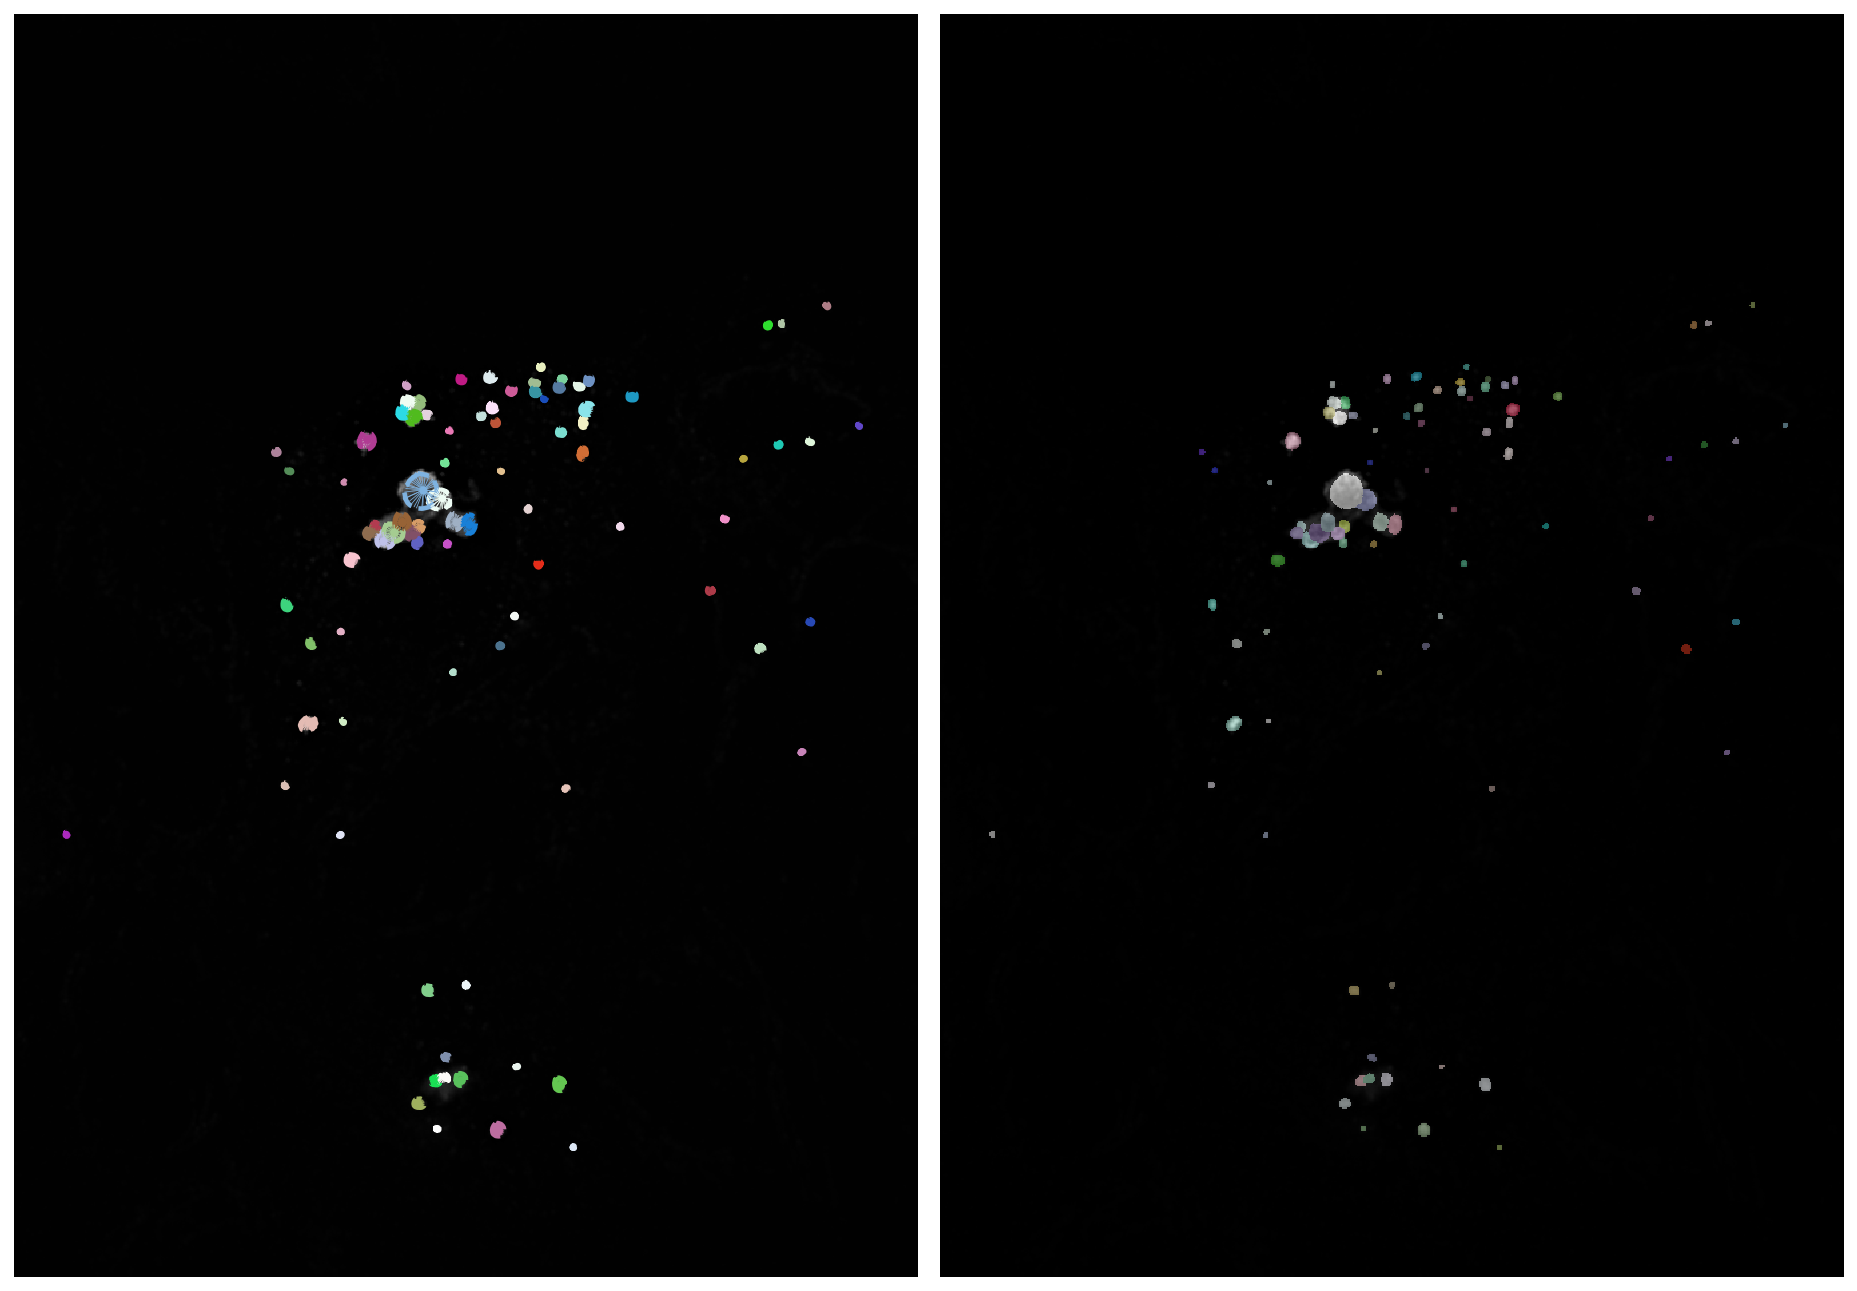

Image en cours de traitement: 20211126_MCF7-STARD3-FYAA-2.tif


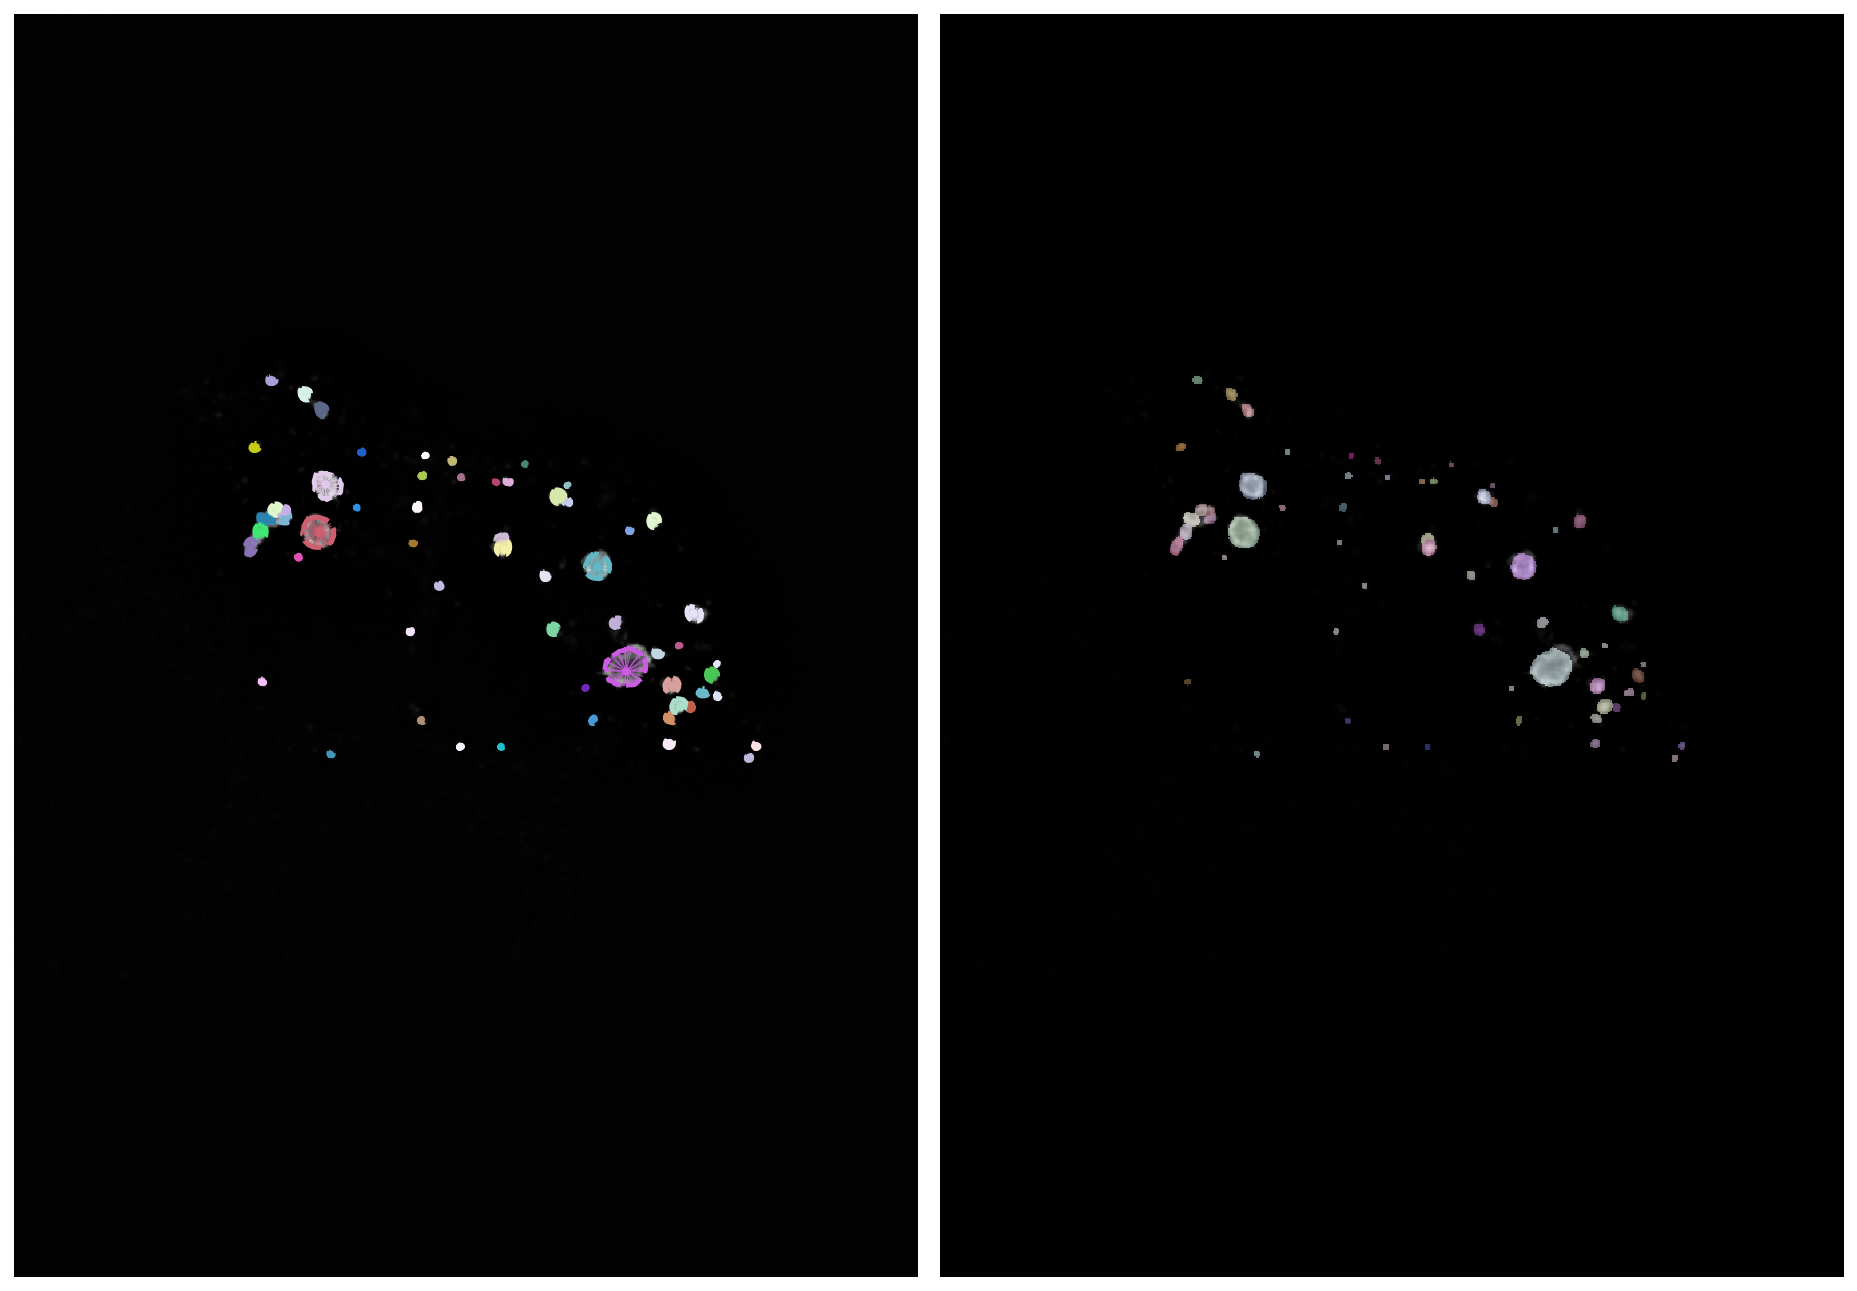

Image en cours de traitement: 20211126_MCF7-STARD3-FYAA-3.tif


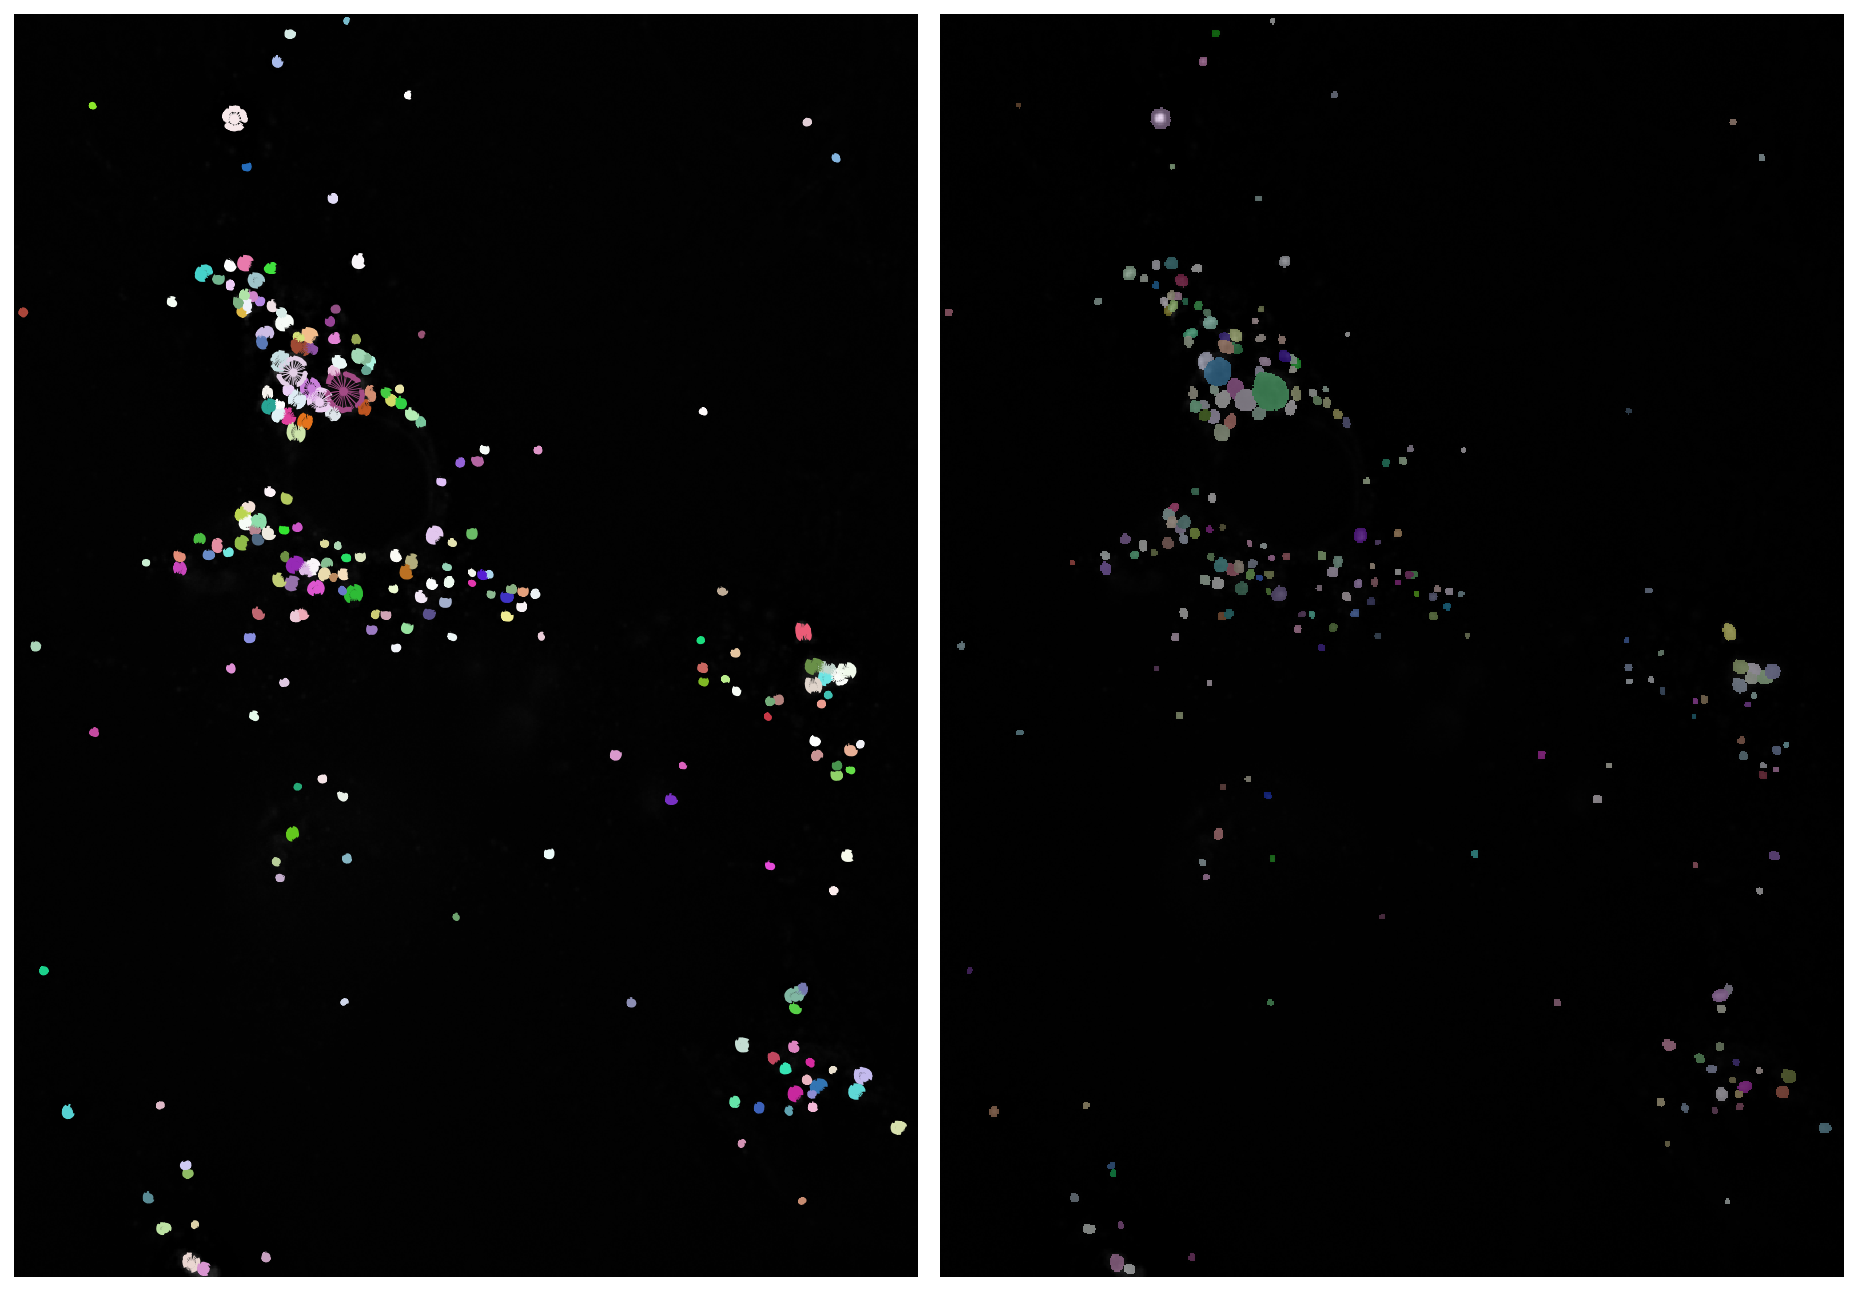

Image en cours de traitement: 20211126_MCF7-STARD3-FYAA-4.tif


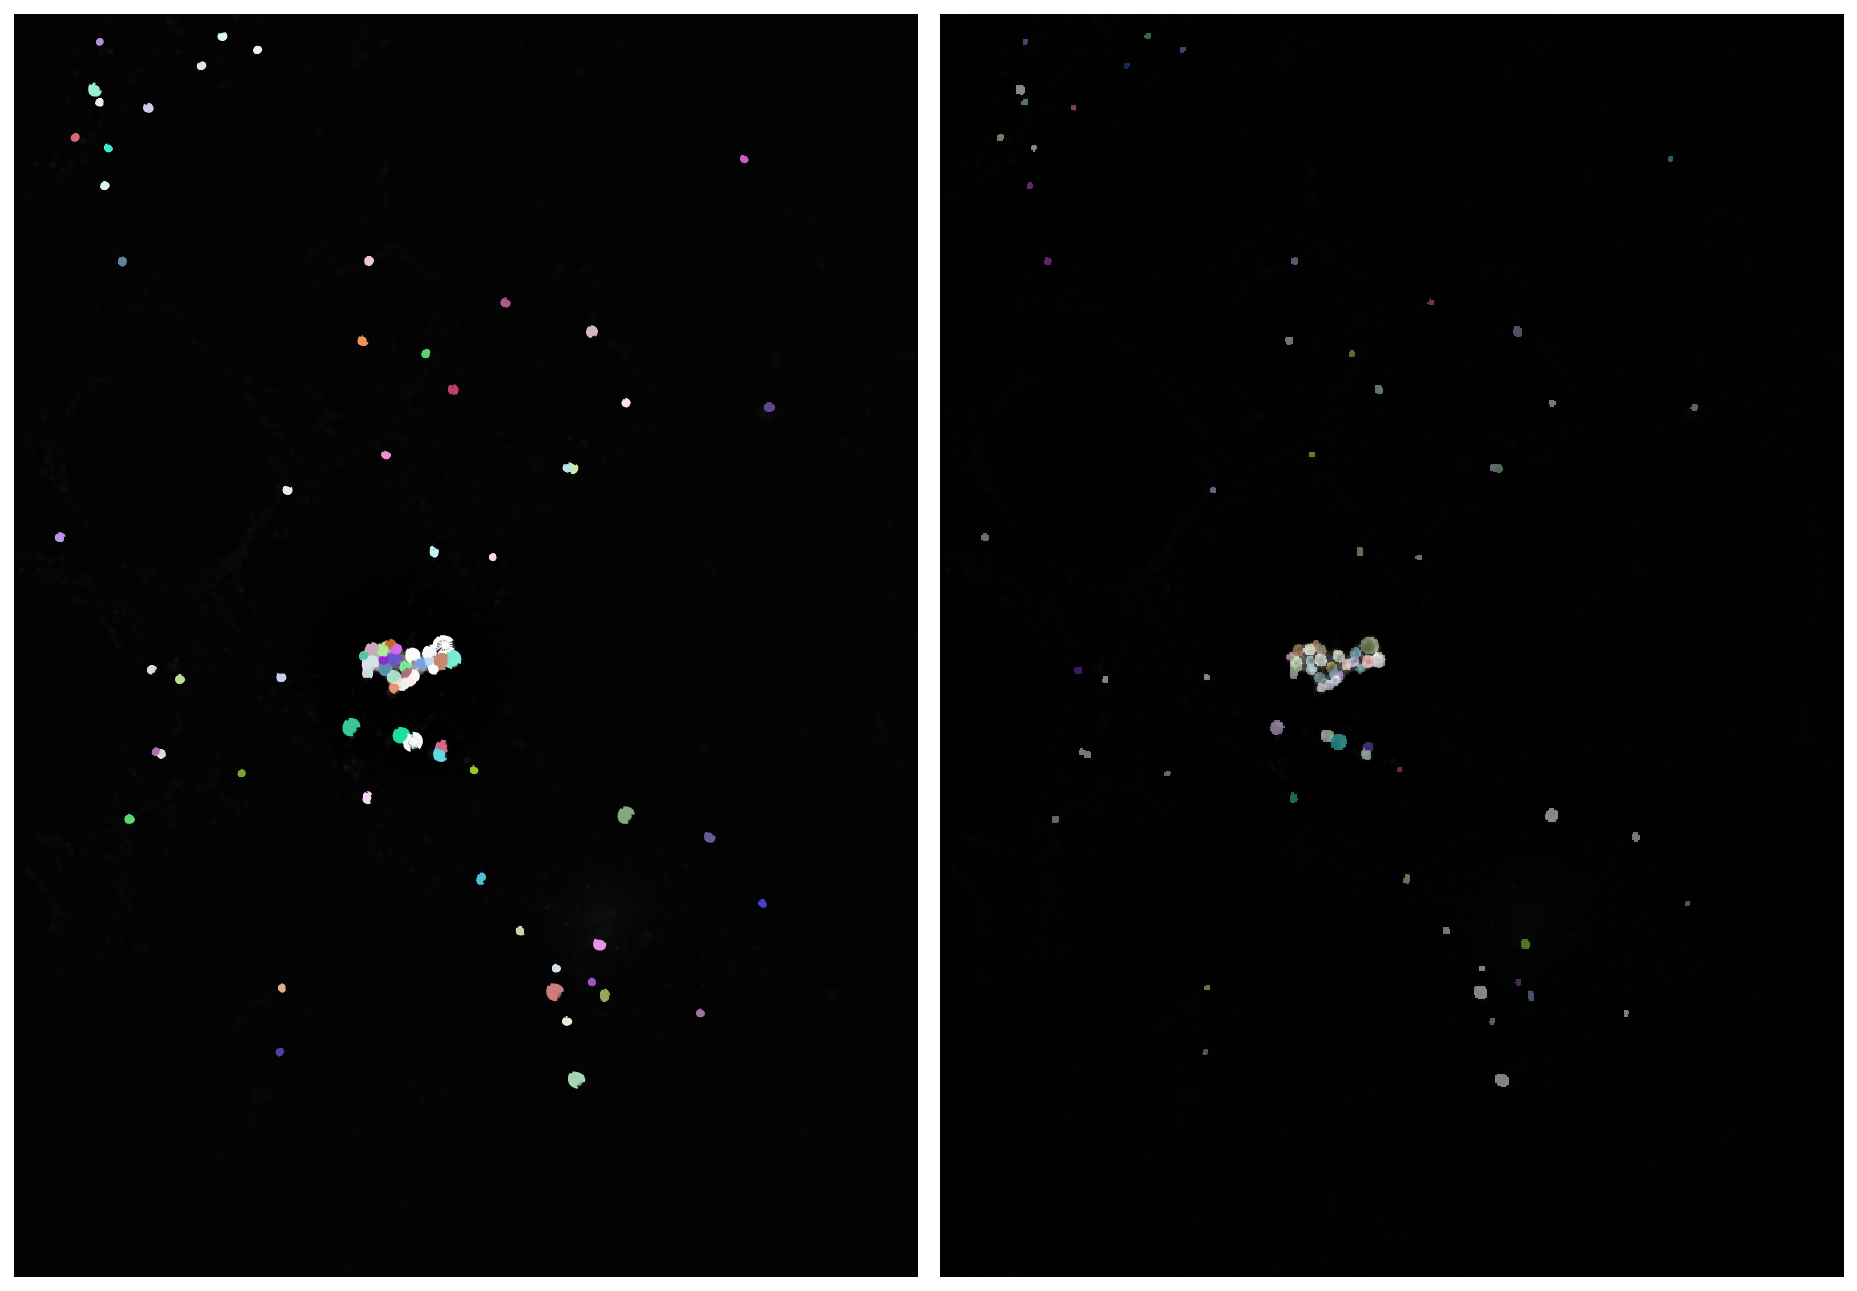

Image en cours de traitement: 20211126_MCF7-STARD3-FYAA-5.tif


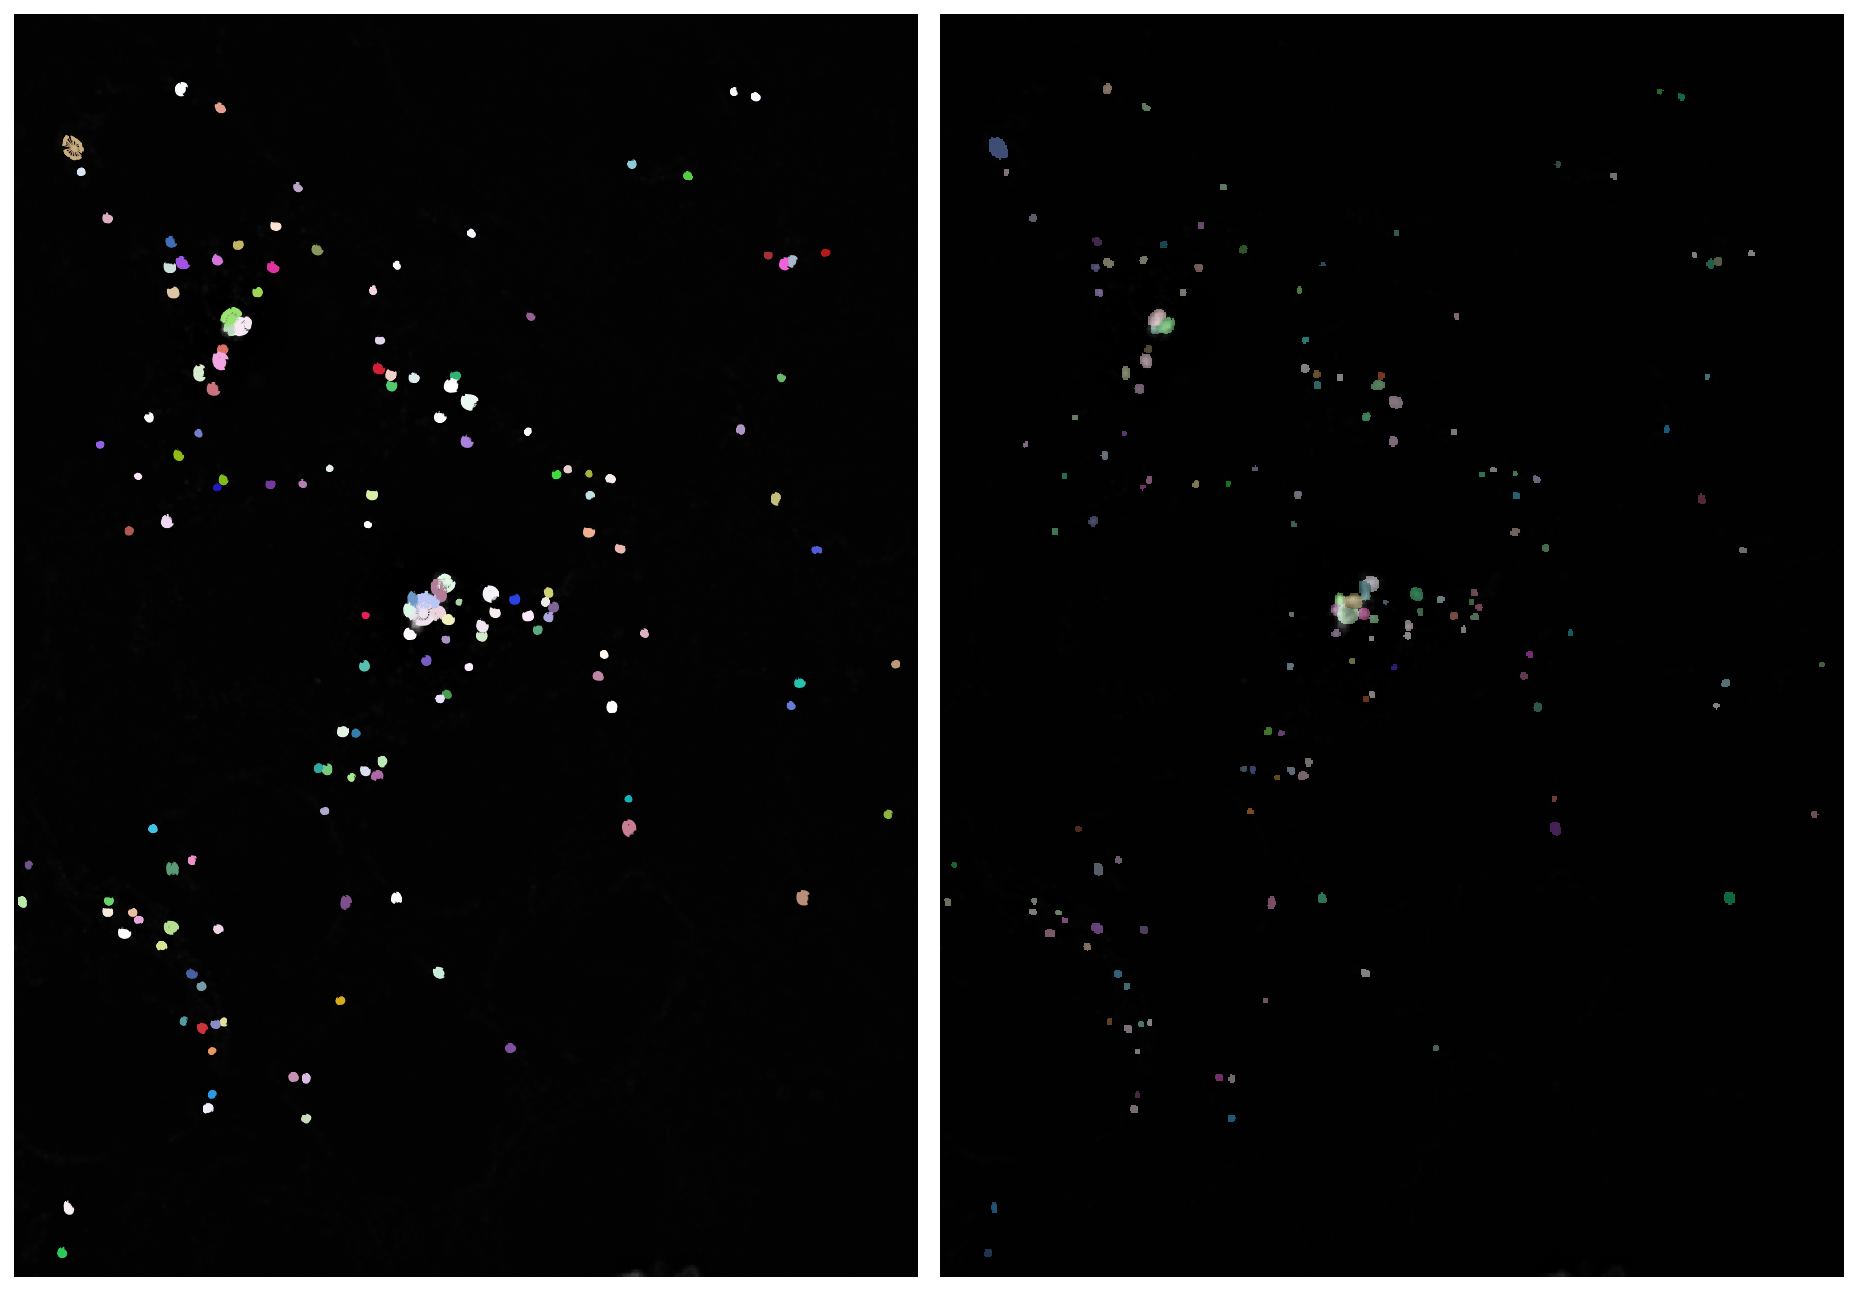

Image en cours de traitement: 20211126_MCF7-STARD3-FYAA-6.tif


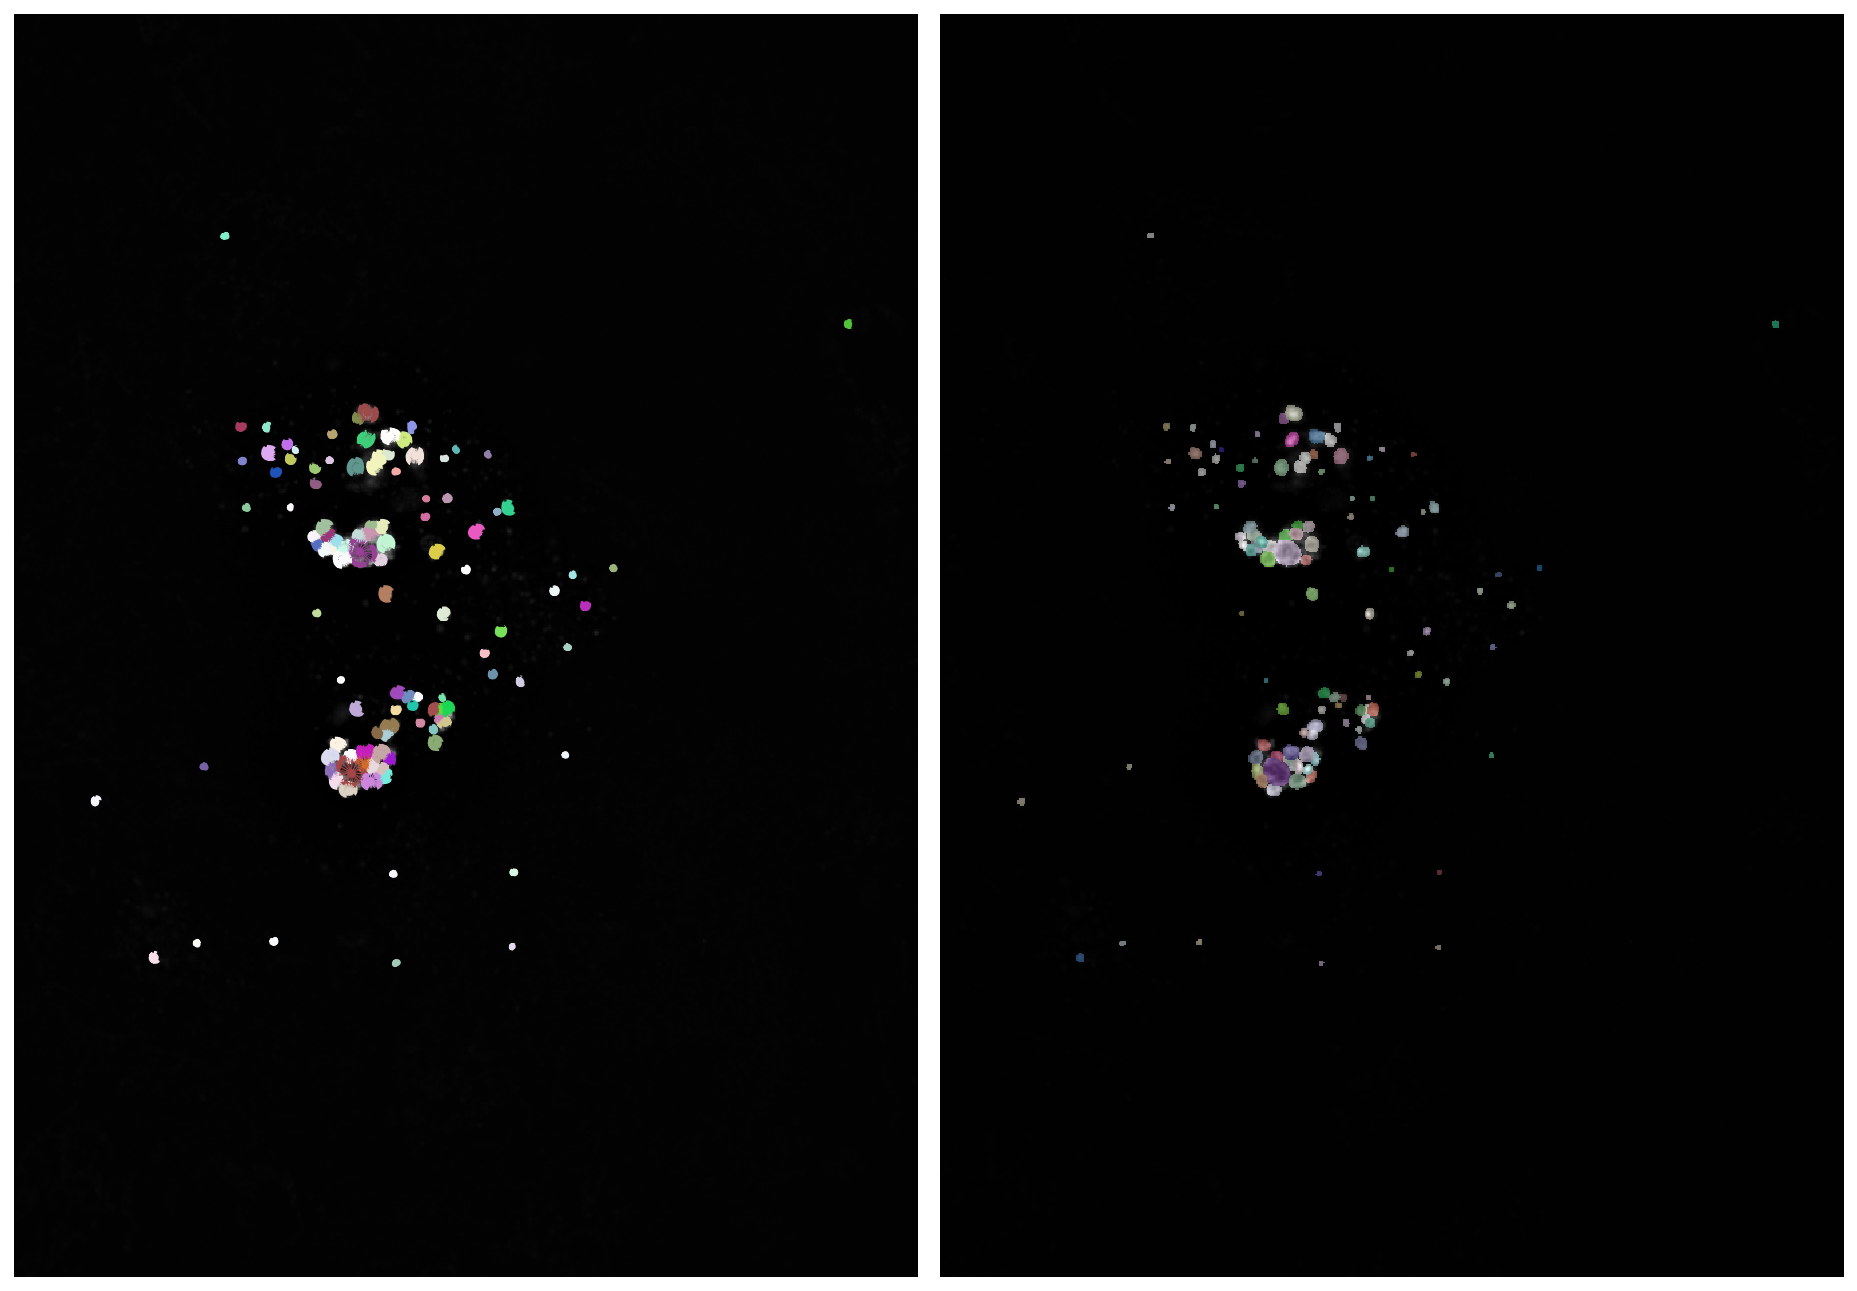

Image en cours de traitement: 20211126_MCF7-STARD3-FYAA-7.tif


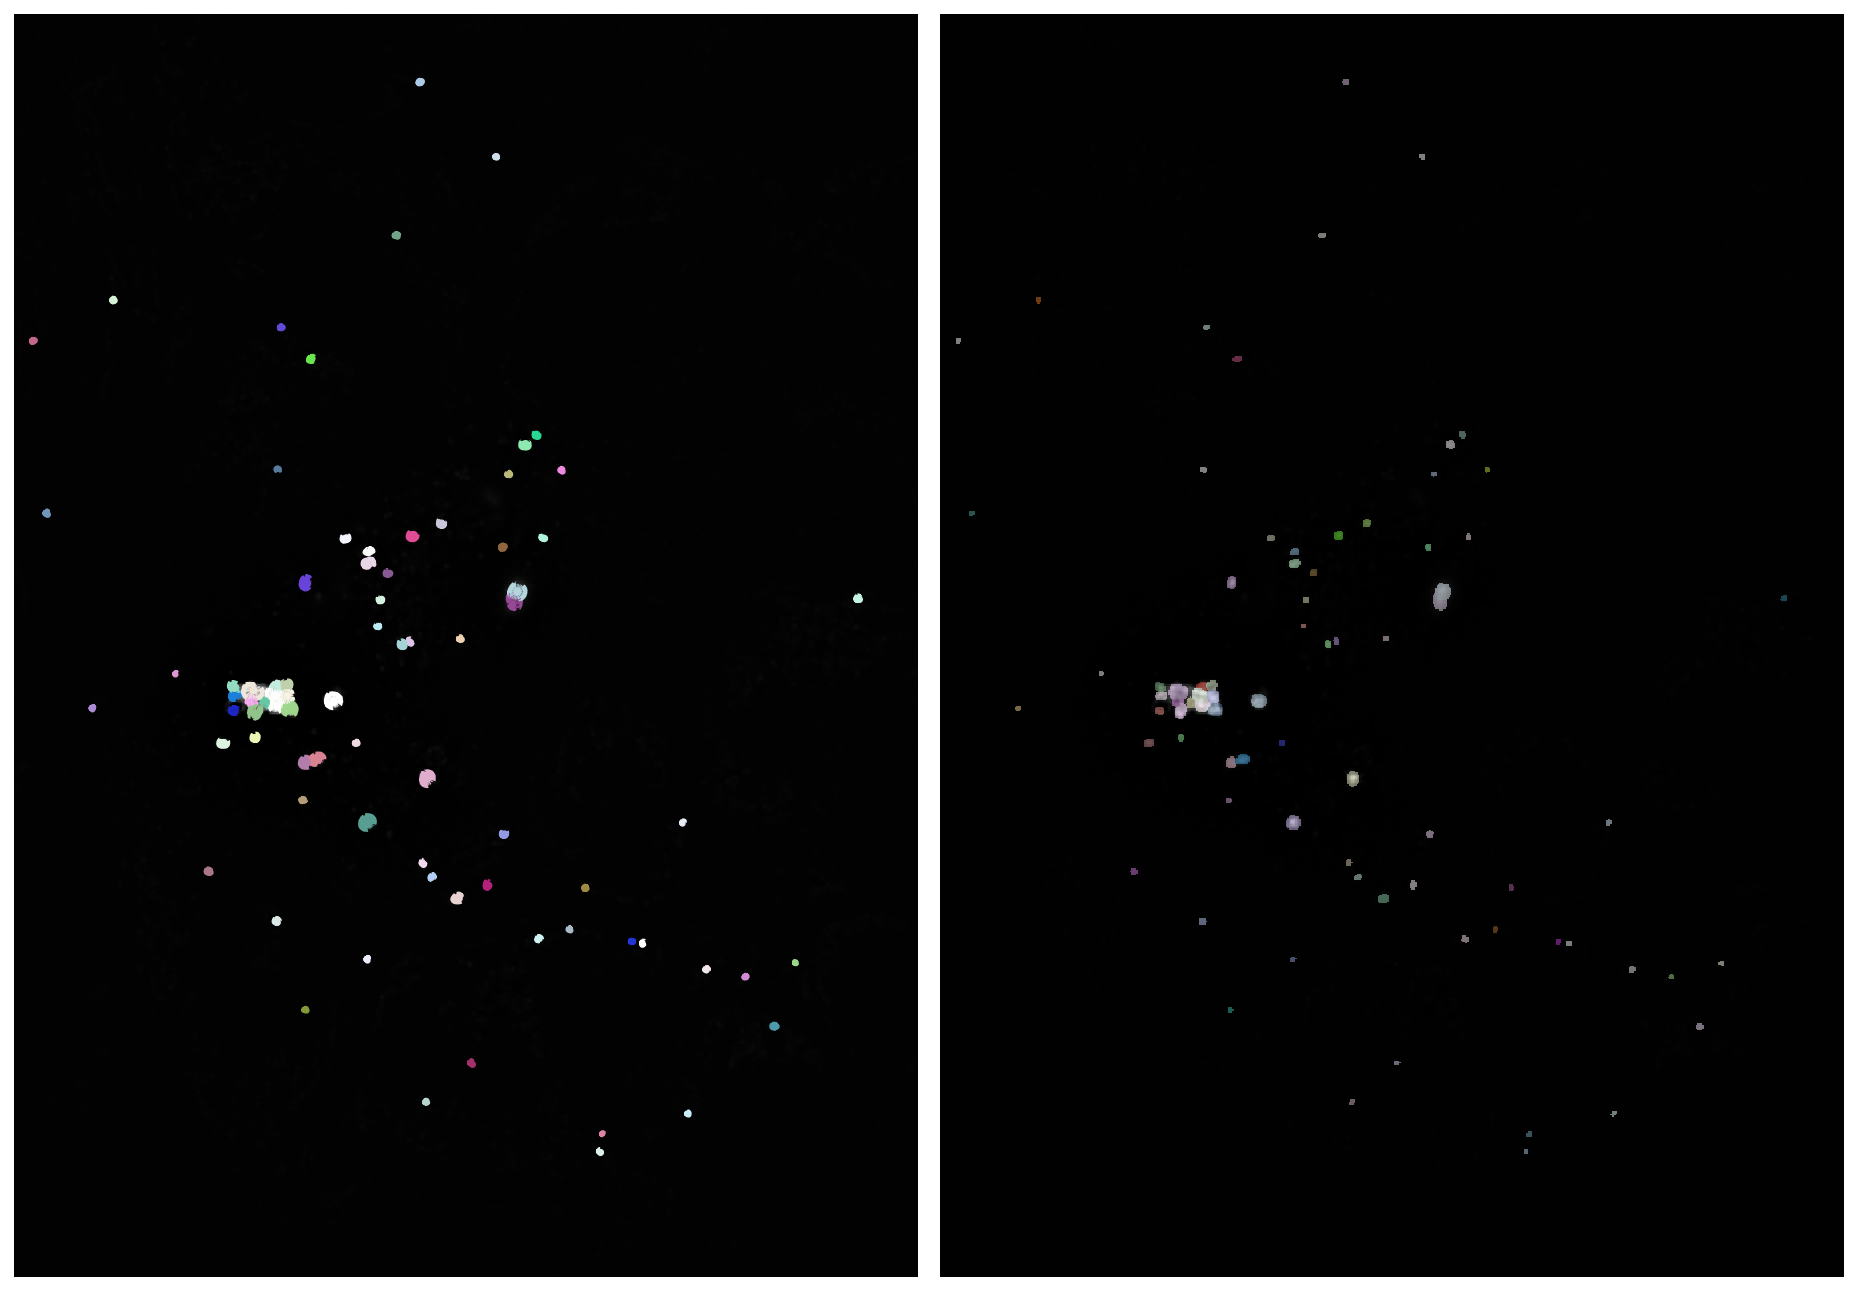

Image en cours de traitement: 20211126_MCF7-STARD3-FYAA-8.tif


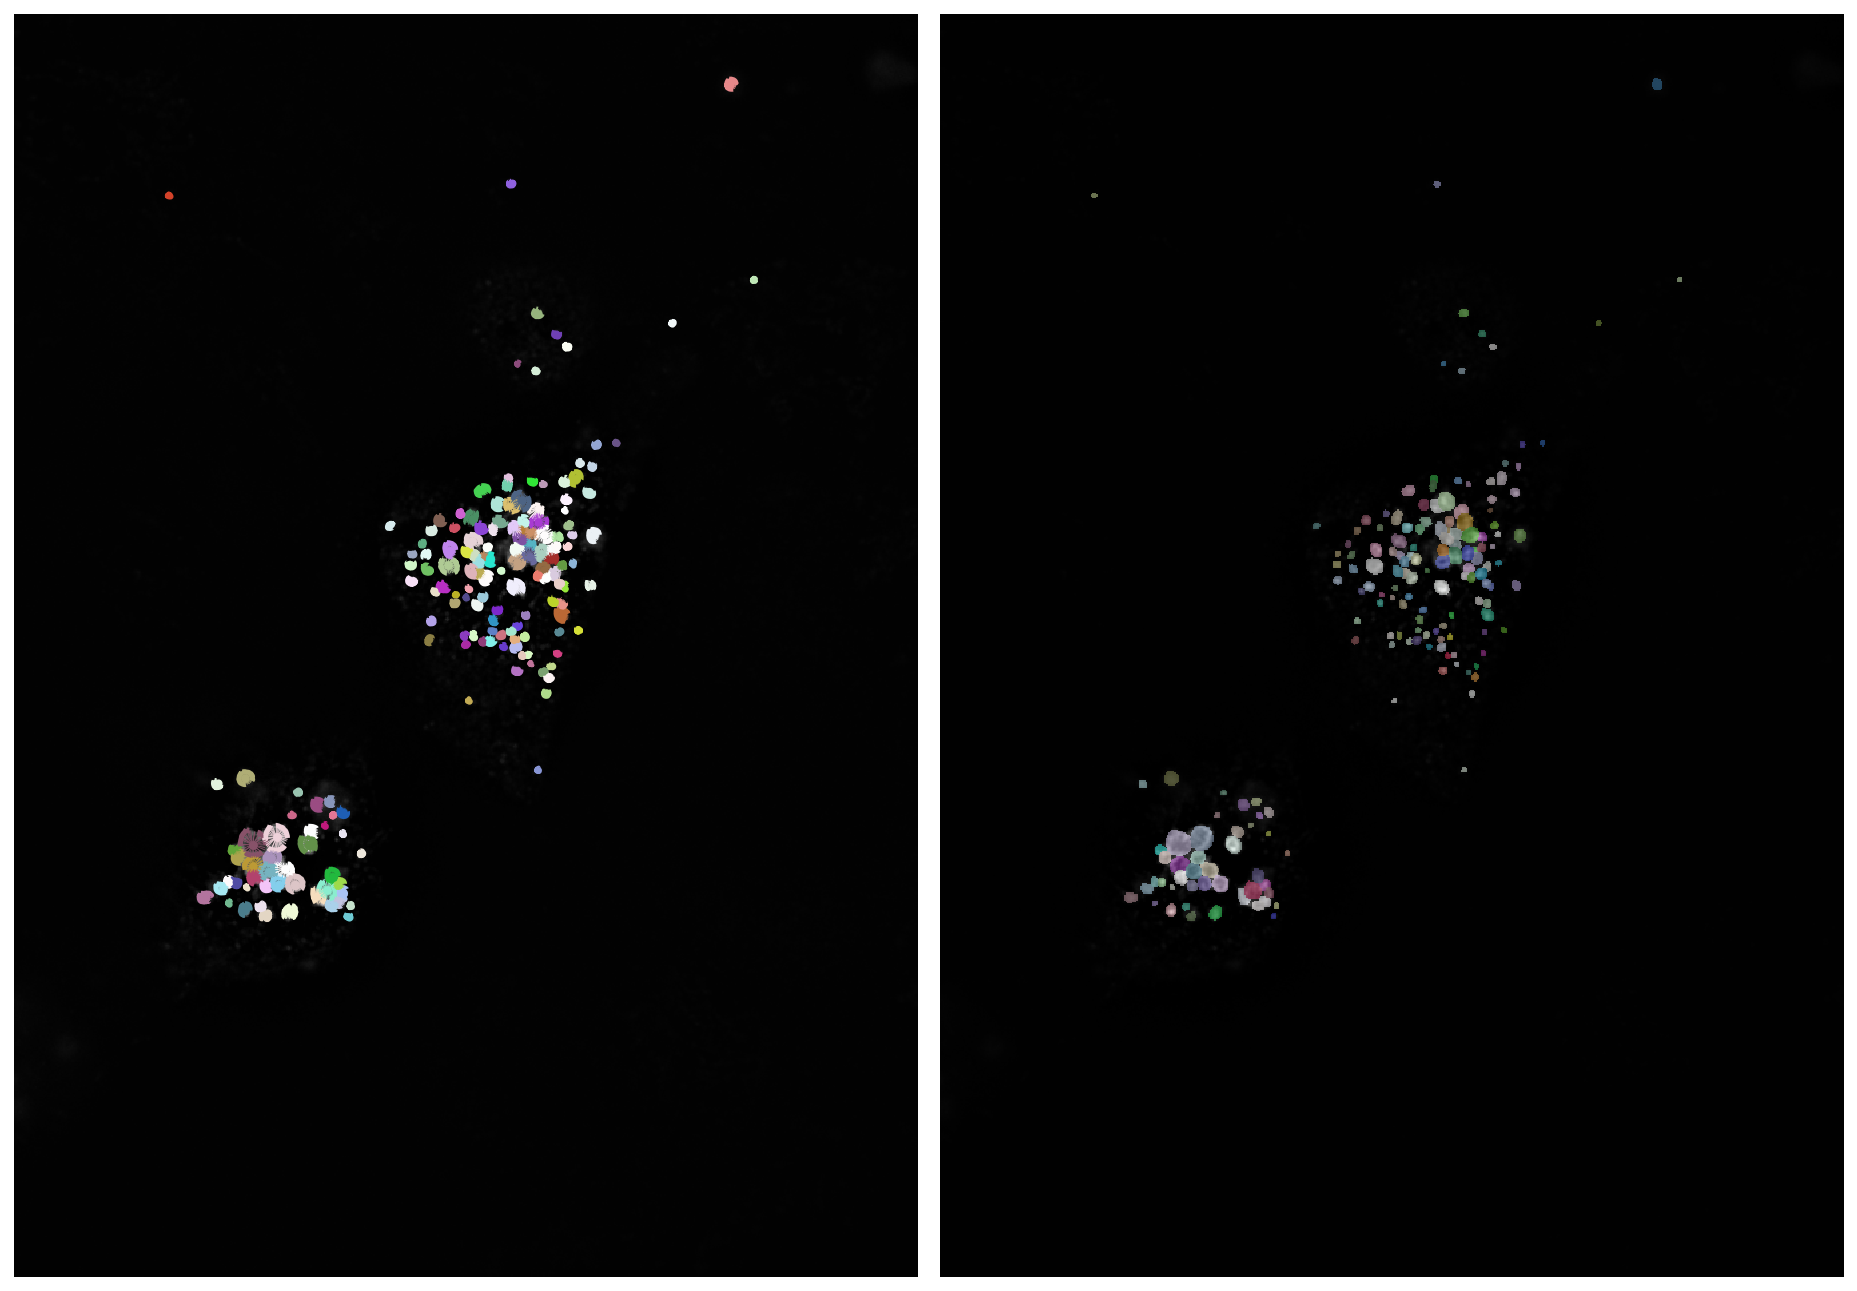

Image en cours de traitement: 20211126_MCF7-STARD3-WT-1.tif


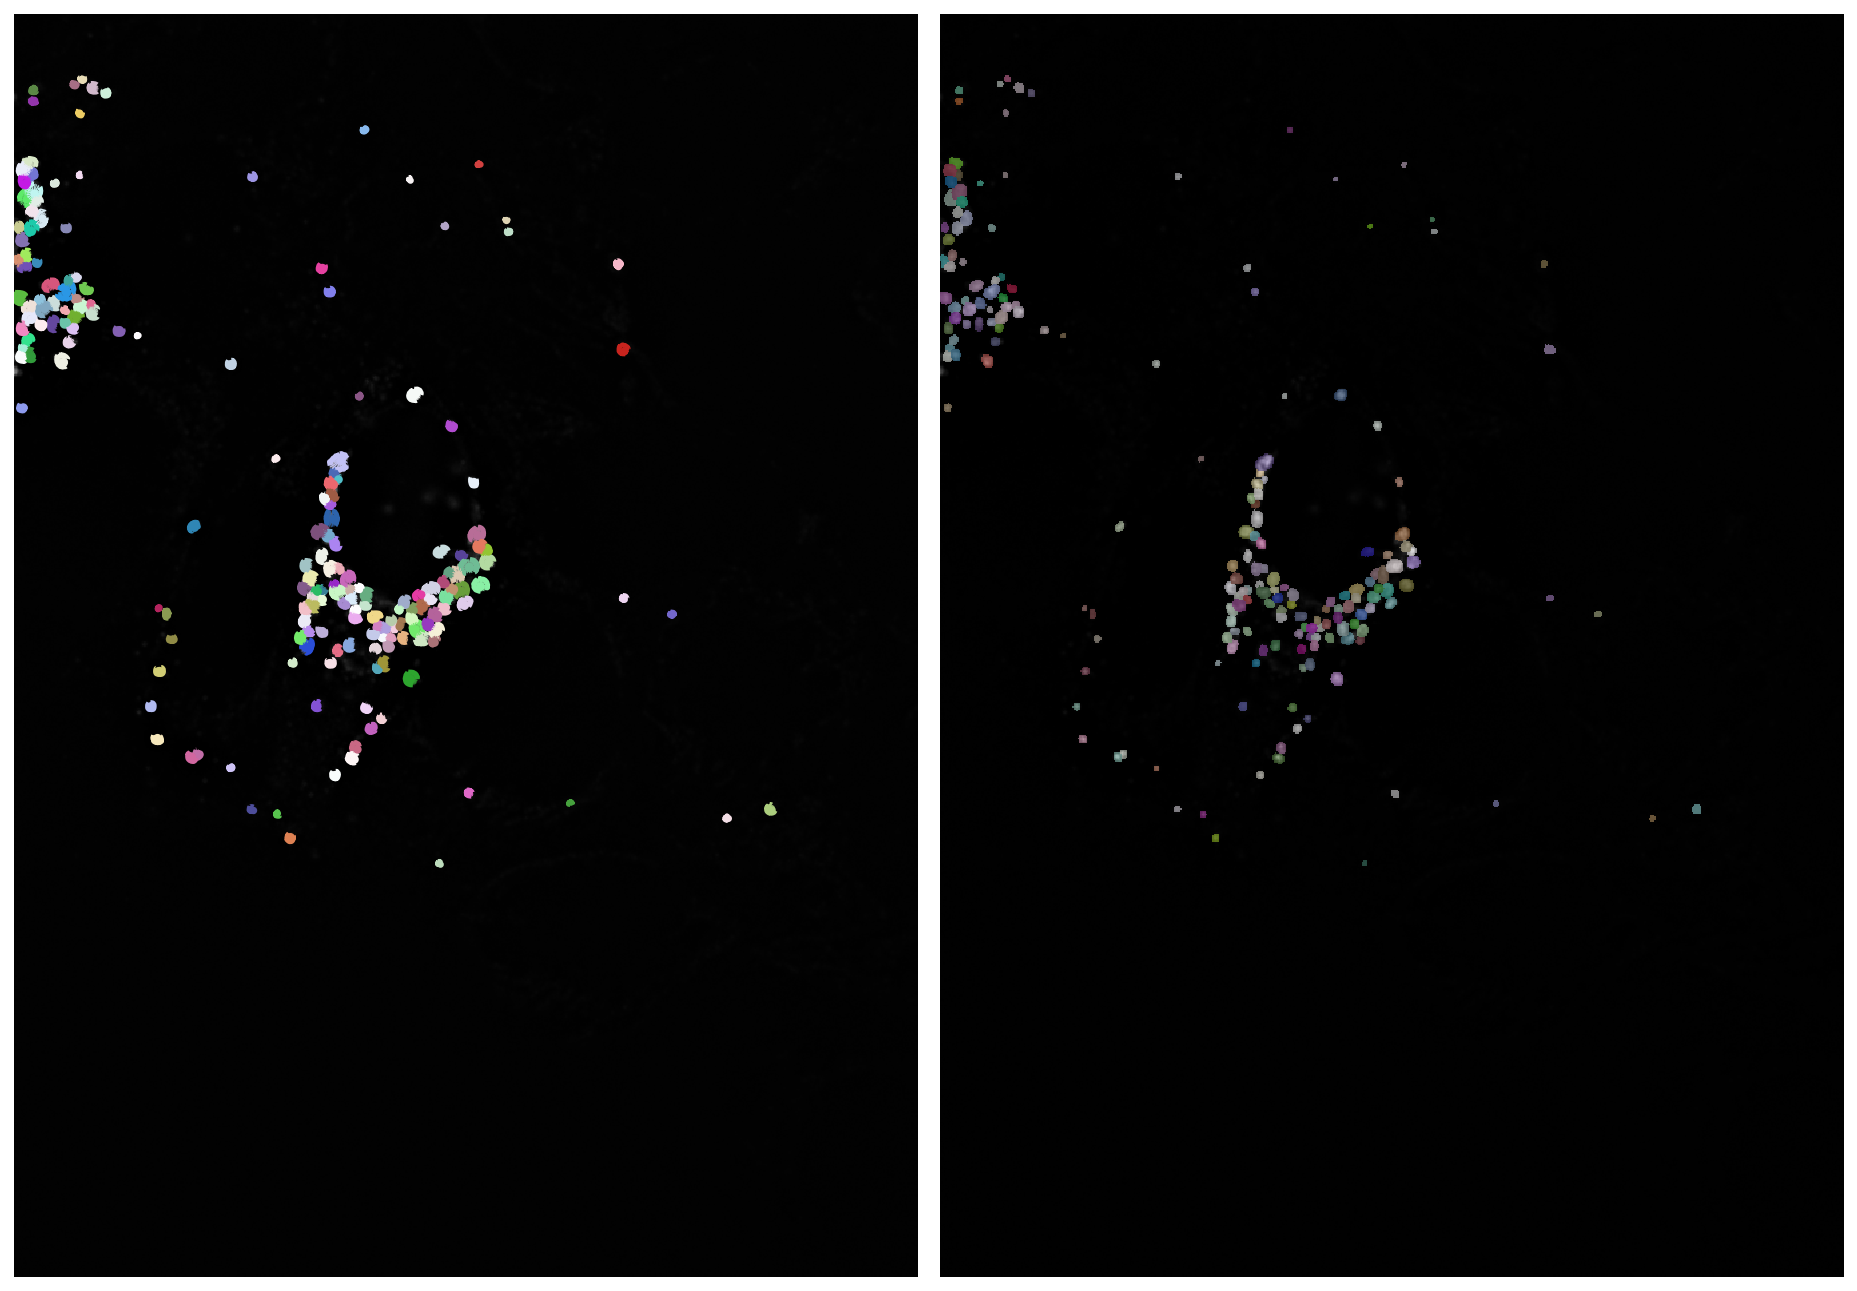

Image en cours de traitement: 20211126_MCF7-STARD3-WT-2.tif


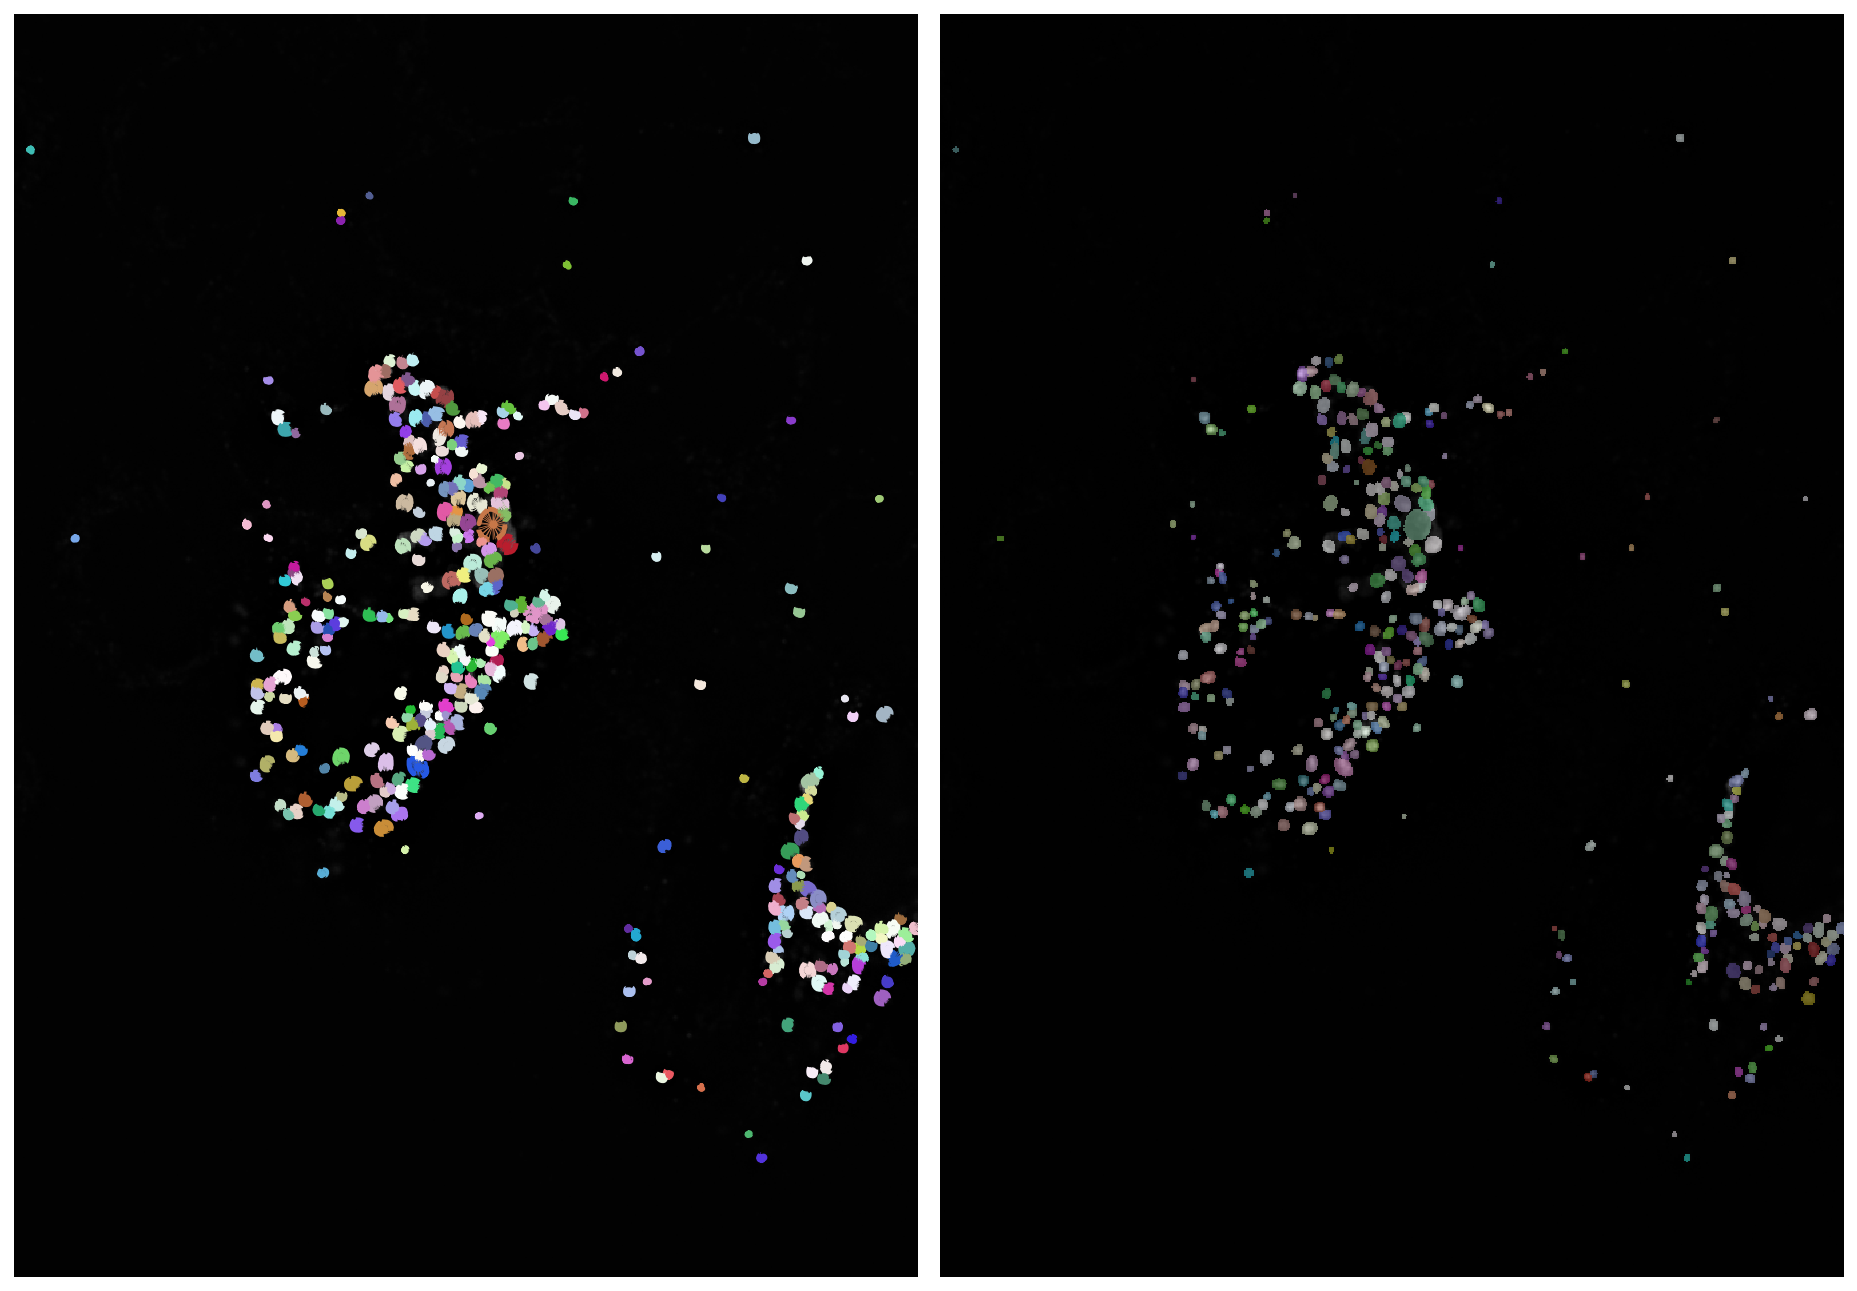

Image en cours de traitement: 20211126_MCF7-STARD3-WT-3.tif


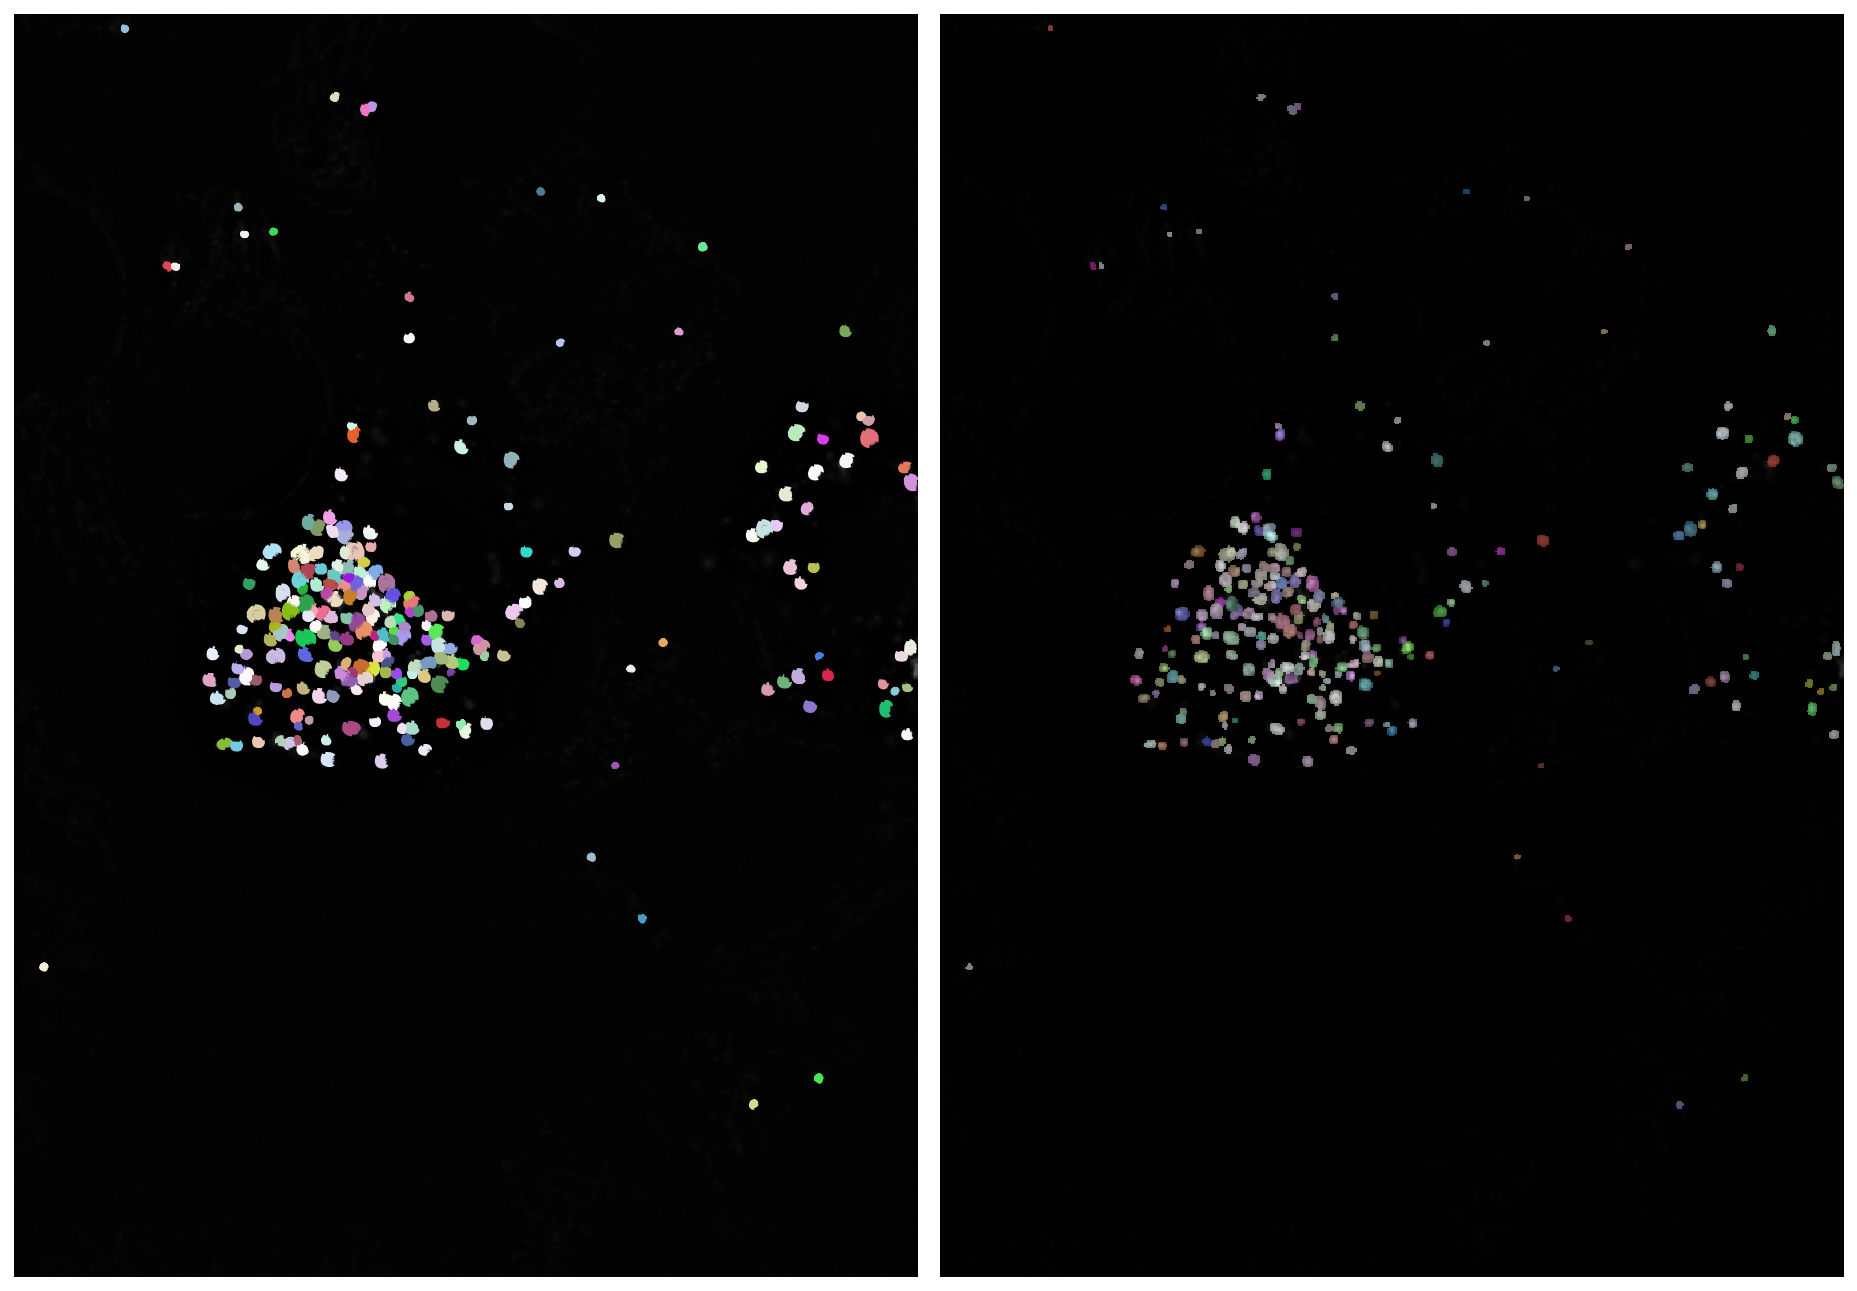

Image en cours de traitement: 20211126_MCF7-STARD3-WT-4.tif


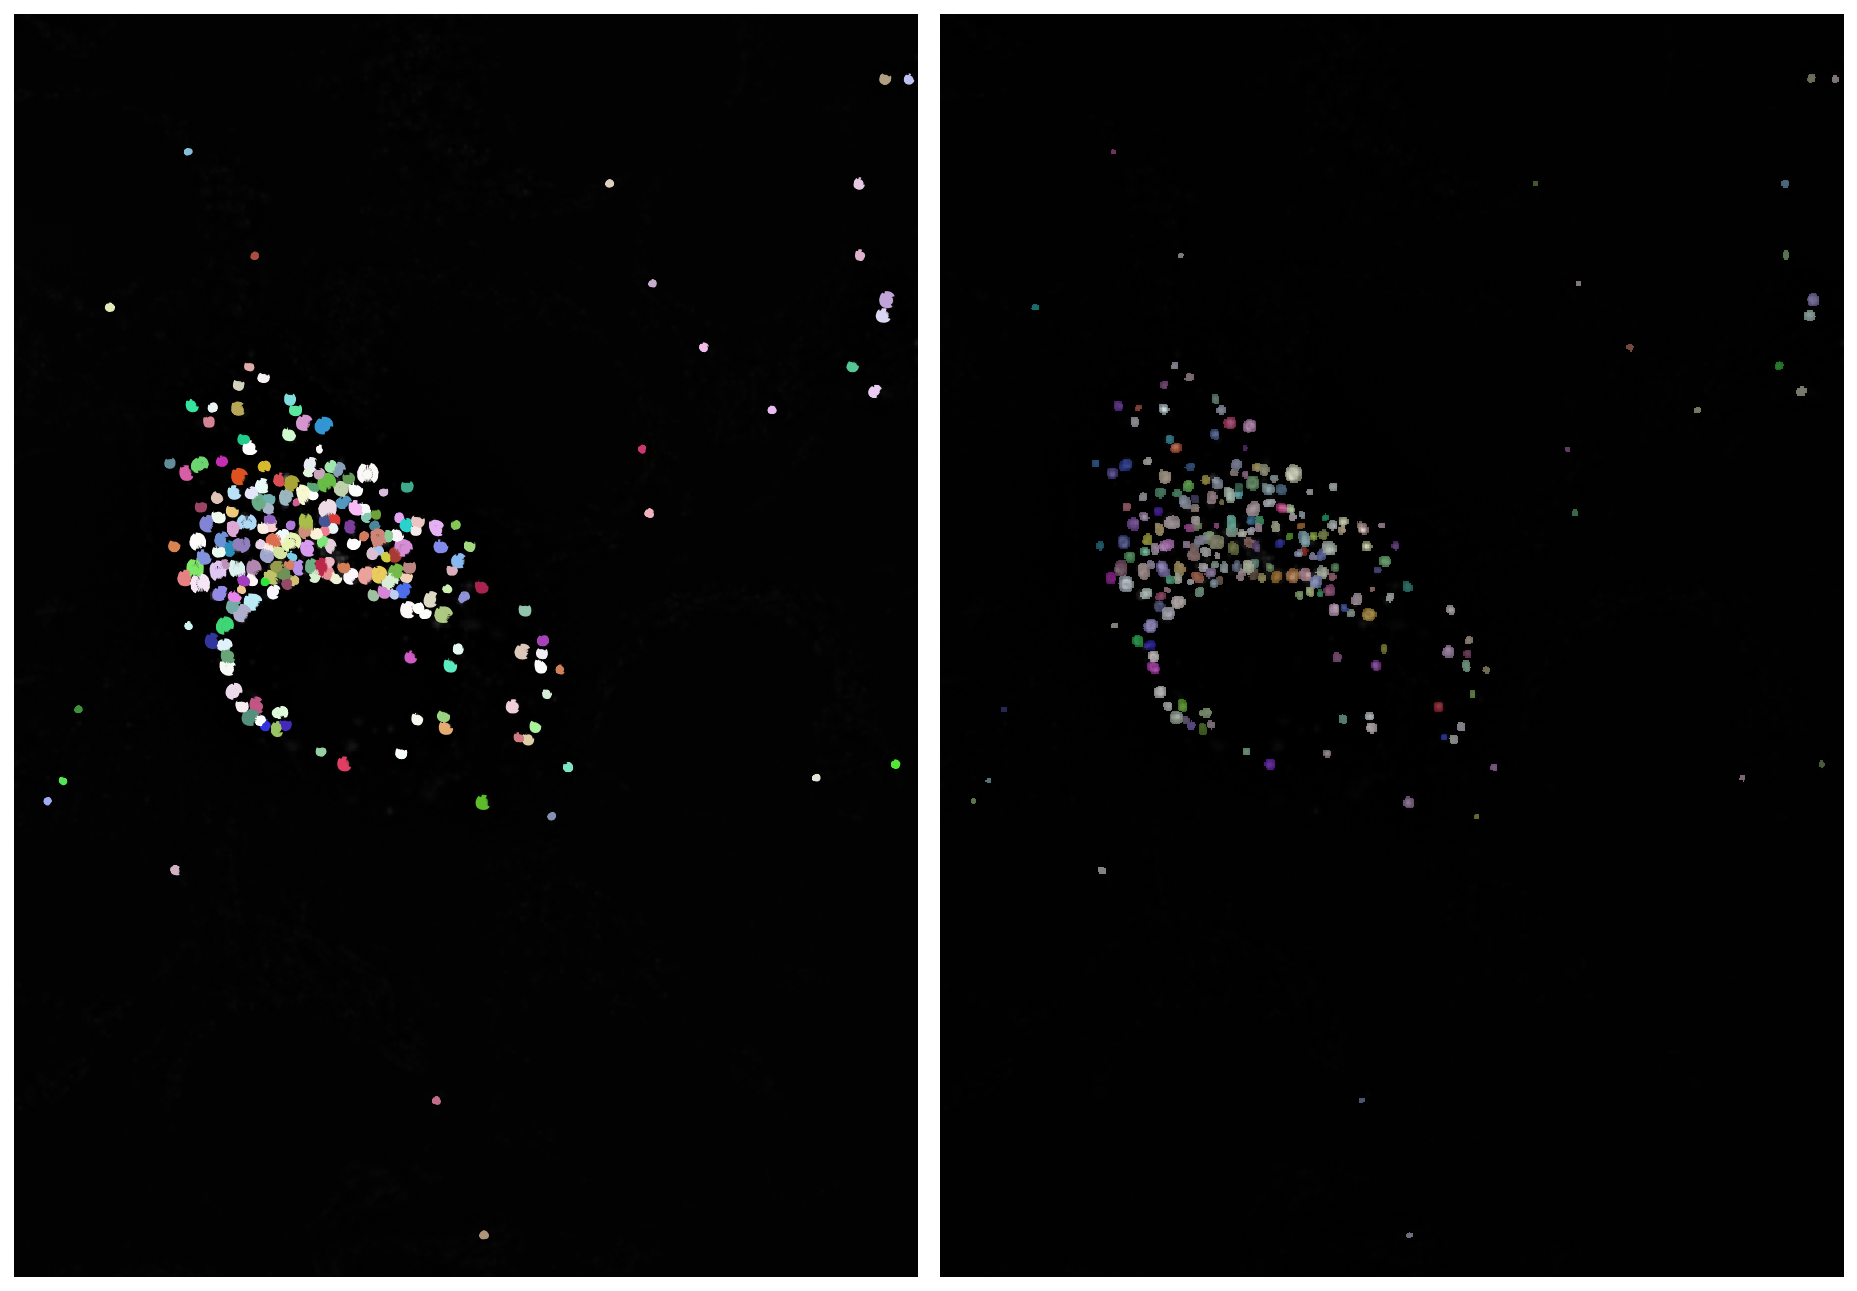

Image en cours de traitement: 20211126_MCF7-STARD3-WT-5.tif


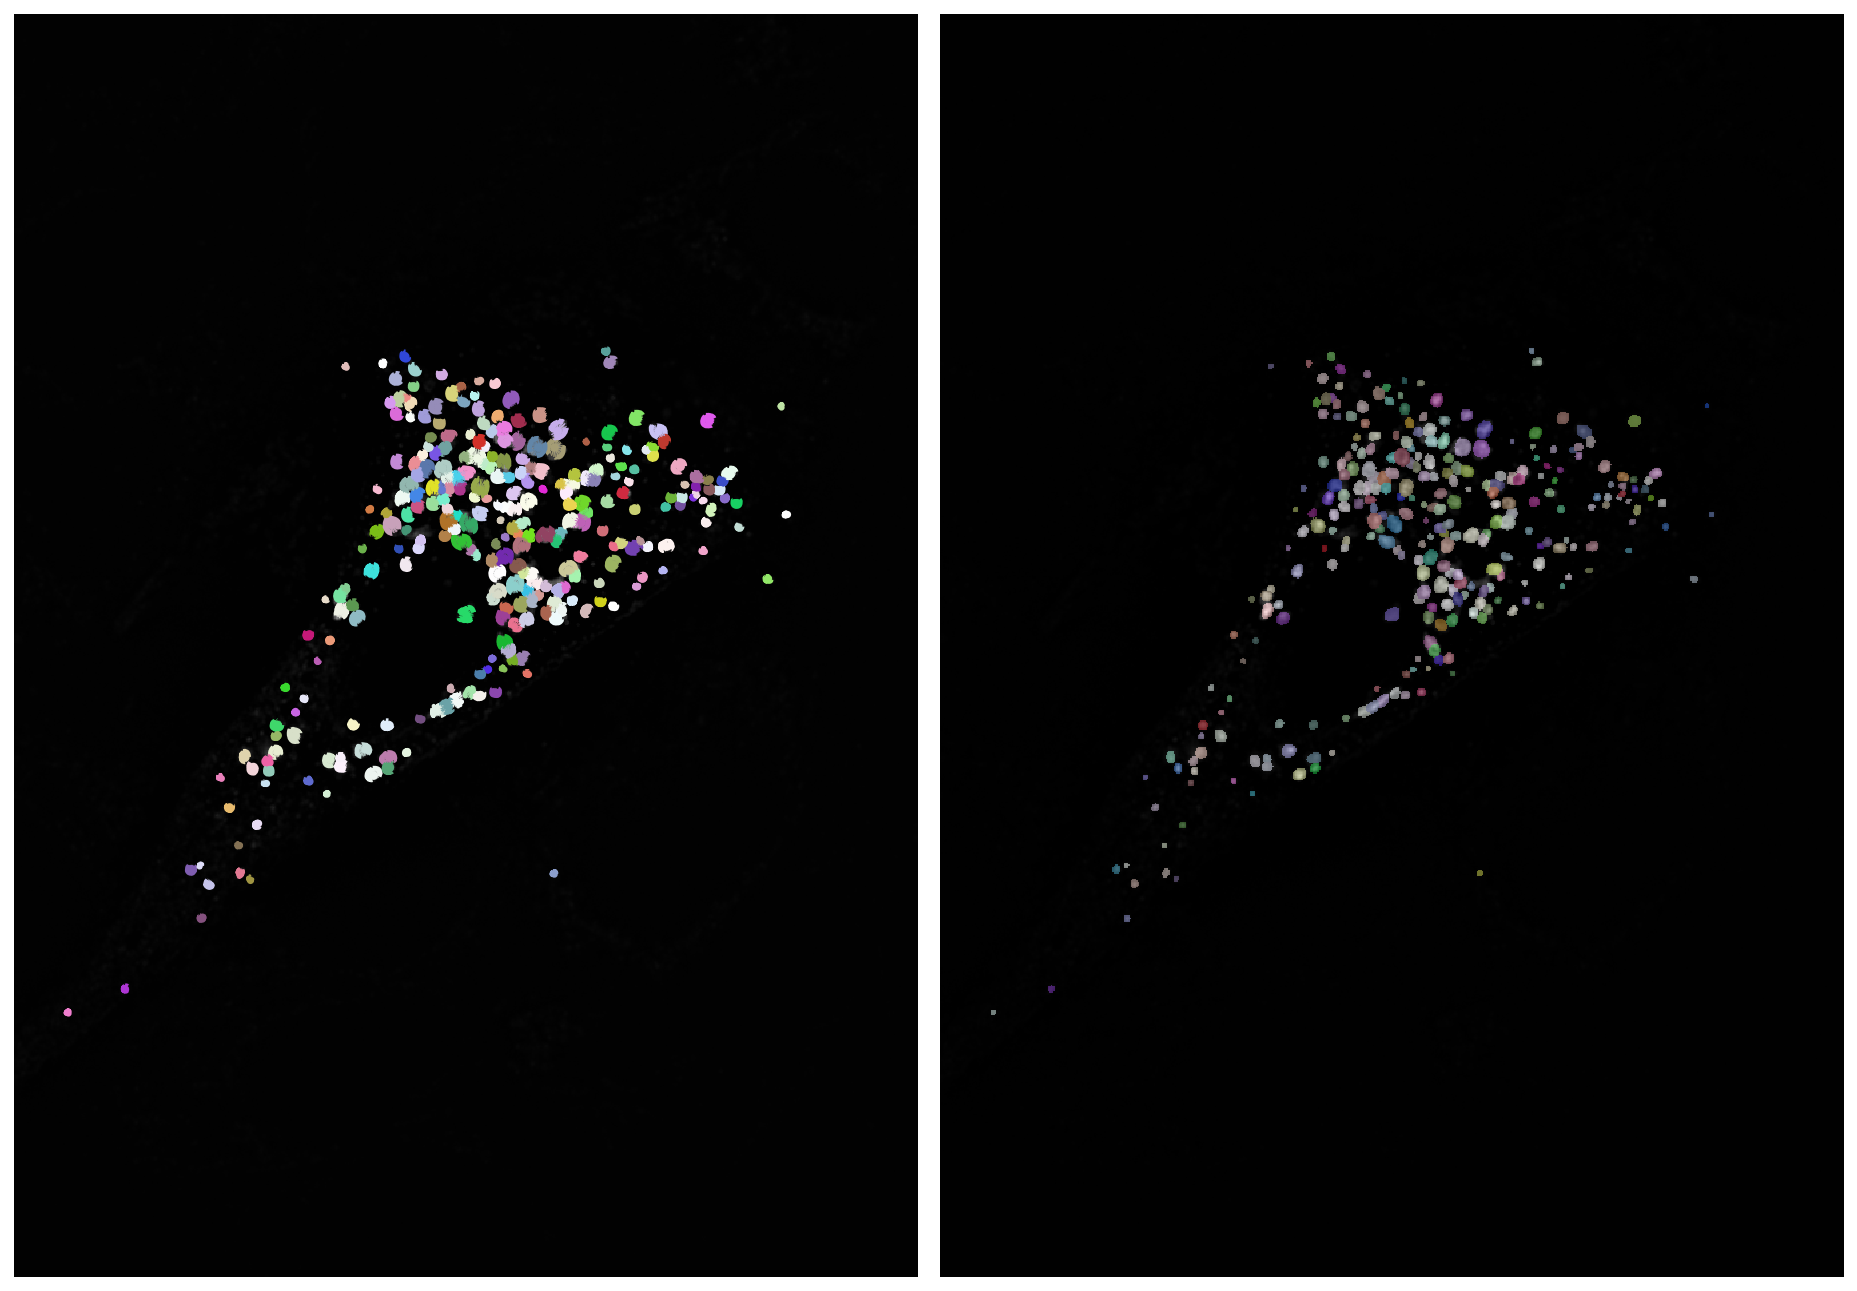

Image en cours de traitement: 20211126_MCF7-STARD3-WT-6.tif


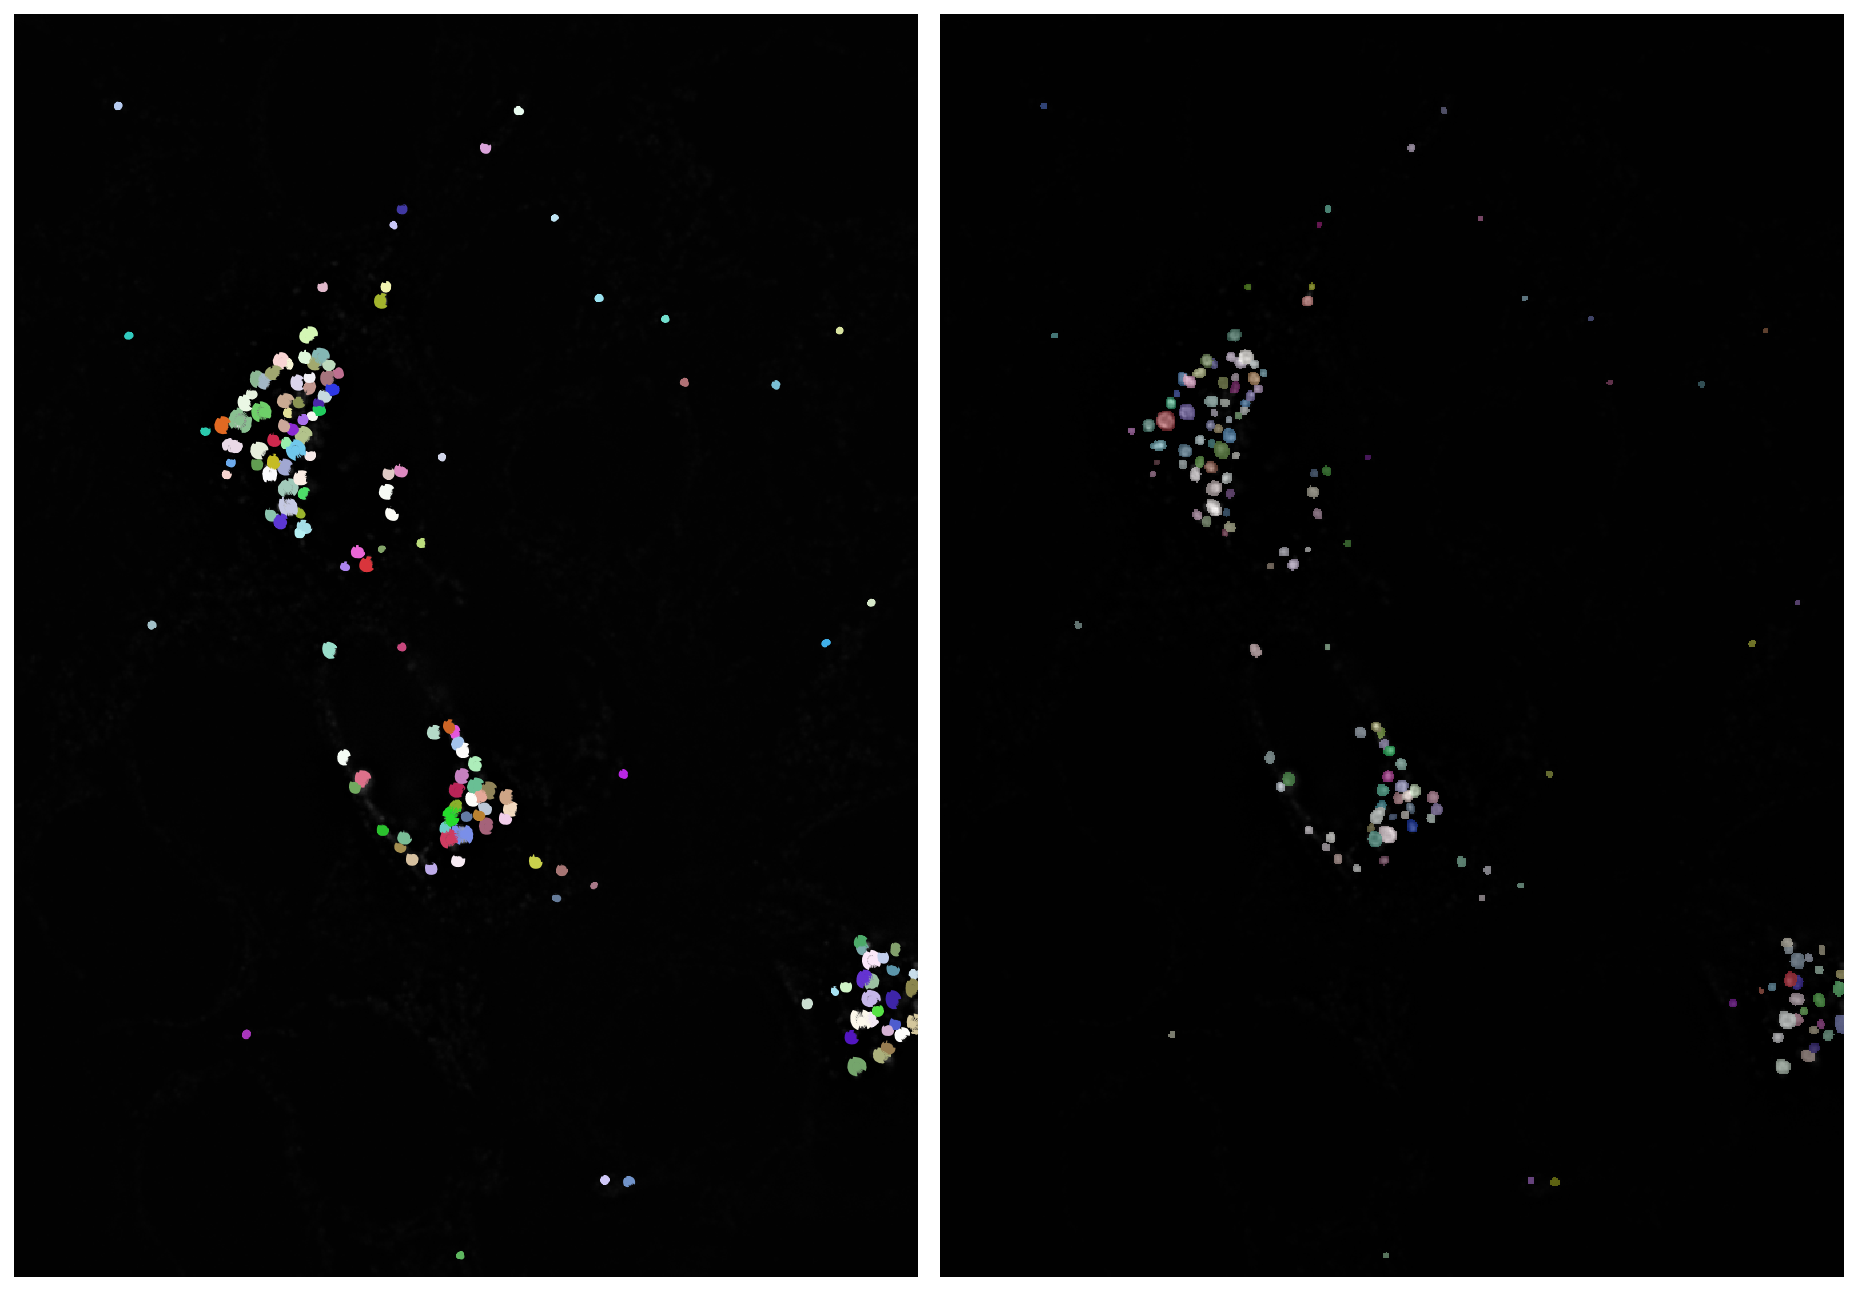

Image en cours de traitement: 20211126_MCF7-STARD3-WT-7.tif


KeyboardInterrupt: 

In [8]:
i = 0
# print(type(i))
while i<=len(X):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)
    names = [os.path.basename(x) for x in glob(path + "/*.tif")]
    
    print("Image en cours de traitement: " + names[i])
#     print("Image numero: " + i)
    
    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=True)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    imsave(pathResult + "/" + names[i]  + ".tiff", labels)
        
    i=i+1
